### Libraries

In [ ]:
!pip install graphkit-learn

import os
from openpyxl import load_workbook
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import scipy
from scipy import stats
from scipy.optimize import minimize
from scipy.special import zeta
from scipy.special import factorial
from scipy.stats import poisson
from scipy import integrate
import random

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.3/386.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 26.8 MB/s eta 0:00:00


### Data

In [ ]:
# Datasets *excluding* large groups
kinsella = 'Kinsella.txt'
kinsella_np = 'Kinsella_NoPretales.txt'
orahilly1e = 'ORahilly_R1_English_GC.xlsx'
orahilly1i = 'ORahilly_R1_Irish.xlsx'
orahilly2 = 'ORahilly_R2_Irish.xlsx'
carson = 'Carson.txt'
nogroups = [orahilly1e,
            orahilly1i,
            orahilly2,
            kinsella,
            kinsella_np,
            carson]

# Datasets *including* large groups
kinsella_g = 'Kinsella_Groups.txt'
kinsella_np_g = 'Kinsella_NoPretales_Groups.txt'
orahilly1_ge = 'ORahilly_R1_English_Groups_GC.xlsx'
orahilly1_gi = 'ORahilly_R1_Irish_Groups.xlsx'
orahilly2_g = 'ORahilly_R2_Irish_Groups.xlsx'
carson_g = 'Carson_Groups.txt'
groups = [kinsella_g,
          kinsella_np_g,
          orahilly1_ge,
          orahilly1_gi,
          orahilly2_g,
          carson_g
          ]

### Alternate Names

In [ ]:
#Create a dictionary to store alternate names
alts = {}

#Read list
chars = []
check = []


chars_data = load_workbook('Characters list_GC.xlsx')
data = chars_data.active
headers = [cell.value for cell in data[1]]
for i in range(2,data.max_row+1):
    u = data[i][0].value
    if u is not None and u[0] == '%':
        continue
    u = u.strip()
    chars.append(u)
    l = [cell.value for cell in data[i][1:data.max_column] if cell.value]
    for a in l:
        a = a.strip()
        if len(a) > 0:
            if a in alts:
                check.append(a)
            alts[a] = u

grouped_datasets = [d for d in groups if d[0] != '.']
nogroups_datasets = [d for d in nogroups if d[0] != '.']

datasets = [d for d in grouped_datasets if d[0] != '.']

graphs = {}
G = nx.Graph()
for d in nogroups:
    #d = datasets[-1]

    #####Excel data:
    if d.split('.')[1] == 'xlsx':
        data = load_workbook(d)
        data = data.active
        headers = [cell.value for cell in data[1]]
        pg = headers.index('Page')
        fr = headers.index('Friendly')

        d = d.split('.')[0]

        #gend = headers.index('Gender')
        for i in range(2,data.max_row+1):
            u = data[i][0].value
            if u != None and u[0] != '%':
                u = u.strip()
                if u in alts:
                    u = alts[u]

                links = [cell.value for cell in data[i][fr:] if cell.value]
                for v in links:
                    v = v.strip()
                    if v in alts:
                        v = alts[v]
                    if len(u) > 1 and len(v) > 1:
                        if G.has_edge(u,v):
                            G.get_edge_data(u,v)['weight'] += 1
                        else:
                            G.add_edge(u,v,weight=1)#, link=ltype)
        graphs[d] = G
        G = nx.Graph()

    else:
        with open(d,'rb') as f:
            headers = f.readline().decode().strip().split('\t')
            d = d.split('.')[0]
            #Get indices
            pg = headers.index('Page')
            fr = headers.index('Friendly')

            #gend = headers.index('Gender')
            for line in f:
                l = line.decode('latin-1').encode("utf-8").decode().strip().split('\t')
                if len(l) > 1:
                    u = l[0]
                    if u != None and u[0] != '%':
                        u = u.strip()
                        if u in alts:
                            u = alts[u]

                        links = [v.strip() for v in l[fr:]]
                        for v in links:
                            v = v.strip()
                            if v in alts:
                                v = alts[v]

                            if len(u) > 1 and len(v) > 1:
                                if G.has_edge(u,v):
                                    G.get_edge_data(u,v)['weight'] += 1
                                else:
                                    G.add_edge(u,v,weight=1)#, link=ltype)


            graphs[d] = G
            G = nx.Graph()

####
for g in graphs:
  N = graphs[g].number_of_nodes() #number of nodes N
  L = graphs[g].number_of_edges() #number of edges L
  degs = []
  for (node,value) in graphs[g].degree():
    degs.append(value)
  totdeg = sum(degs)
  k_avg = totdeg/N #average degree <k>
  degdiff = []
  for i in degs:
    degdiff.append((i-k_avg)**2)
  k_delta = sum(degdiff)/N #degree delta <k^2>#
  r = nx.degree_assortativity_coefficient(graphs[g]) #assortativity r
  C = nx.average_clustering(graphs[g]) #clustering coefficient C

  if nx.is_connected(graphs[g]) == False:
    avgpaths = []
    for x in nx.connected_components(graphs[g]):
      subgraphs = graphs[g].subgraph(x)
      avgpaths.append(nx.average_shortest_path_length(subgraphs))
      l_avg = max(avgpaths) #average path length l_avg
  else:
    l_avg = nx.average_shortest_path_length(graphs[g]) #average path length l_avg

  EM = 0.5772
  lrand = 0.5 + (np.log(N)-EM)/np.log(k_avg) #average path length of a random network of the same size l_rand
  Crand = k_avg/(N-1) #clustering coefficient of a randomly generated network of the same size C_rand

  k_seq = sorted(graphs[g].degree, key=lambda x: x[1], reverse=True) #top 5 characters in order of degree

  bet = nx.betweenness_centrality(graphs[g])
  bet_seq = {k: v for k, v in sorted(bet.items(), key=lambda item: item[1], reverse=True)} #top 5 characters in order of betweennes

  degdist = np.array(list(dict(graphs[g].degree()).values())) #degree distribution
  k,n_k = np.unique(degdist,return_counts=True)
  p_k = n_k/degdist.size #probability mass function
  P = (np.cumsum(n_k[::-1])[::-1])/degdist.size #CCDF

  number_of_characters = [0,1,2,3,4,5,6,7,8,9]

  table_degree = PrettyTable() #table of the top 10 nodes with the highest degree
  table_degree.field_names = ['Rank', 'Character', 'Degree']
  for i in number_of_characters:
    table_degree.add_row([i+1, k_seq[i][0], k_seq[i][1]])

  table_betweenness = PrettyTable() #table of the top 10 nodes with the highest betweenness
  table_betweenness.field_names = ['Rank', 'Character', 'Betweenness']
  for i in number_of_characters:
    table_betweenness.add_row([i+1, list(bet_seq)[i], round(list(bet_seq.values())[i],2)])
  print('\n', graphs[g], '\n',
        N,'\n',
        L,'\n',
        round(k_avg,2),'\n',
        round(k_delta,2),'\n',
        round(r,2),'\n',
        round(C,2),'\n',
        round(l_avg,2), '\n\n',
        round(Crand, 2),'\n',
        round(lrand,4), '\n',
        table_betweenness, '\n',
        table_degree, '\n\n\n')


 Graph with 246 nodes and 545 edges 
 246 
 545 
 4.43 
 121.9 
 -0.31 
 0.42 
 2.62 

 0.02 
 3.8106 
 +------+---------------------+-------------+
| Rank |      Character      | Betweenness |
+------+---------------------+-------------+
|  1   |     Cú Chulainn     |     0.71    |
|  2   |   Fergus mac Róich  |     0.23    |
|  3   |        Ailill       |     0.13    |
|  4   |         Medb        |     0.1     |
|  5   |      Conchobar      |     0.06    |
|  6   | Cethern mac Fintain |     0.04    |
|  7   |       Bricriu       |     0.03    |
|  8   |      Etarcomol      |     0.02    |
|  9   |        Némain       |     0.02    |
|  10  |   Lóegaire Búadach  |     0.01    |
+------+---------------------+-------------+ 
 +------+---------------------+--------+
| Rank |      Character      | Degree |
+------+---------------------+--------+
|  1   |     Cú Chulainn     |  148   |
|  2   |   Fergus mac Róich  |   57   |
|  3   |         Medb        |   50   |
|  4   |        Ailill 

### Combined Data

In [ ]:
g1 = graphs['ORahilly_R1_Irish']
g2 = graphs['ORahilly_R2_Irish']
G = nx.compose(g1,g2)
N = G.number_of_nodes() #number of nodes N
L = G.number_of_edges() #number of edges L
degs = []
for (node,value) in G.degree():
  degs.append(value)
totdeg = sum(degs)
k_avg = totdeg/N #average degree <k>
degdiff = []
for i in degs:
  degdiff.append((i-k_avg)**2)
k_delta = sum(degdiff)/N #degree delta <k^2>
r = nx.degree_assortativity_coefficient(G) #assortativity r
C = nx.average_clustering(G) #clustering coefficient C

if nx.is_connected(G) == False:
  avgpaths = []
  for x in nx.connected_components(G):
    subgraphs = G.subgraph(x)
    avgpaths.append(nx.average_shortest_path_length(subgraphs))
    l_avg = max(avgpaths) #average path length l_avg
else:
  l_avg = nx.average_shortest_path_length(G) #average path length l_avg

EM = 0.5772
lrand = 0.5 + (np.log(N)-EM)/np.log(k_avg) #average path length of a random network of the same size l_rand
Crand = k_avg/(N-1) #clustering coefficient of a randomly generated network of the same size C_rand

k_seq = sorted(G.degree, key=lambda x: x[1], reverse=True) #top 5 characters in order of degree

bet = nx.betweenness_centrality(G)
bet_seq = {k: v for k, v in sorted(bet.items(), key=lambda item: item[1], reverse=True)} #top 5 characters in order of betweennes

degdist = np.array(list(dict(G.degree()).values())) #degree distribution
k,n_k = np.unique(degdist,return_counts=True)
p_k = n_k/degdist.size #probability mass function
P = (np.cumsum(n_k[::-1])[::-1])/degdist.size #CCDF

number_of_characters = [0,1,2,3,4,5,6,7,8,9]

table_degree = PrettyTable() #table of the top 10 nodes with the highest degree
table_degree.field_names = ['Rank', 'Character', 'Degree']
for i in number_of_characters:
  table_degree.add_row([i+1, k_seq[i][0], k_seq[i][1]])

table_betweenness = PrettyTable() #table of the top 10 nodes with the highest betweenness
table_betweenness.field_names = ['Rank', 'Character', 'Betweenness']
for i in number_of_characters:
  table_betweenness.add_row([i+1, list(bet_seq)[i], round(list(bet_seq.values())[i],2)])
print('\n', graphs[g], '\n',
        N,'\n',
        L,'\n',
        round(k_avg,2),'\n',
        round(k_delta,2),'\n',
        round(r,2),'\n',
        round(C,2),'\n',
        round(l_avg,2), '\n\n',
        round(Crand, 2),'\n',
        round(lrand,4), '\n',
        table_betweenness, '\n',
        table_degree, '\n\n\n')


 Graph with 287 nodes and 799 edges 
 318 
 805 
 5.06 
 156.22 
 -0.3 
 0.44 
 2.71 

 0.02 
 3.6967 
 +------+---------------------+-------------+
| Rank |      Character      | Betweenness |
+------+---------------------+-------------+
|  1   |     Cú Chulainn     |     0.63    |
|  2   |   Fergus mac Róich  |     0.21    |
|  3   |         Medb        |     0.15    |
|  4   |        Ailill       |     0.12    |
|  5   |      Conchobar      |     0.07    |
|  6   | Cethern mac Fintain |     0.04    |
|  7   |         Láeg        |     0.03    |
|  8   |       Fer Diad      |     0.03    |
|  9   |       Mac Roth      |     0.03    |
|  10  |       Bricriu       |     0.02    |
+------+---------------------+-------------+ 
 +------+---------------------+--------+
| Rank |      Character      | Degree |
+------+---------------------+--------+
|  1   |     Cú Chulainn     |  174   |
|  2   |         Medb        |   84   |
|  3   |   Fergus mac Róich  |   78   |
|  4   |        Ailill 

### Grouped Data

In [ ]:
graphs = {}
G = nx.Graph()
for d in groups:
    #d = datasets[-1]

    #####Excel data:
    if d.split('.')[1] == 'xlsx':
        data = load_workbook(d)
        data = data.active
        headers = [cell.value for cell in data[1]]
        pg = headers.index('Page')
        fr = headers.index('Friendly')

        d = d.split('.')[0]

        #gend = headers.index('Gender')
        for i in range(2,data.max_row+1):
            u = data[i][0].value
            if u != None and u[0] != '%':
                u = u.strip()
                if u in alts:
                    u = alts[u]

                links = [cell.value for cell in data[i][fr:] if cell.value]
                for v in links:
                    v = v.strip()
                    if v in alts:
                        v = alts[v]
                    if len(u) > 1 and len(v) > 1:
                        if G.has_edge(u,v):
                            G.get_edge_data(u,v)['weight'] += 1
                        else:
                            G.add_edge(u,v,weight=1)#, link=ltype)
        graphs[d] = G
        G = nx.Graph()

    else:
        with open(d,'rb') as f:
            headers = f.readline().decode().strip().split('\t')
            d = d.split('.')[0]
            #Get indices
            pg = headers.index('Page')
            fr = headers.index('Friendly')

            #gend = headers.index('Gender')
            for line in f:
                l = line.decode('latin-1').encode("utf-8").decode().strip().split('\t')
                if len(l) > 1:
                    u = l[0]
                    if u != None and u[0] != '%':
                        u = u.strip()
                        if u in alts:
                            u = alts[u]

                        links = [v.strip() for v in l[fr:]]
                        for v in links:
                            v = v.strip()
                            if v in alts:
                                v = alts[v]

                            if len(u) > 1 and len(v) > 1:
                                if G.has_edge(u,v):
                                    G.get_edge_data(u,v)['weight'] += 1
                                else:
                                    G.add_edge(u,v,weight=1)#, link=ltype)


            graphs[d] = G
            G = nx.Graph()

####
for g in graphs:
  N = graphs[g].number_of_nodes() #number of nodes N
  L = graphs[g].number_of_edges() #number of edges L
  degs = []
  for (node,value) in graphs[g].degree():
    degs.append(value)
  totdeg = sum(degs)
  k_avg = totdeg/N #average degree <k>
  degdiff = []
  for i in degs:
    degdiff.append((i-k_avg)**2)
  k_delta = sum(degdiff)/N #degree delta <k^2>
  r = nx.degree_assortativity_coefficient(graphs[g]) #assortativity r
  C = nx.average_clustering(graphs[g]) #clustering coefficient C

  if nx.is_connected(graphs[g]) == False:
    avgpaths = []
    for x in nx.connected_components(graphs[g]):
      subgraphs = graphs[g].subgraph(x)
      avgpaths.append(nx.average_shortest_path_length(subgraphs))
      l_avg = max(avgpaths) #average path length l_avg
  else:
    l_avg = nx.average_shortest_path_length(graphs[g]) #average path length l_avg

  EM = 0.5772
  lrand = 0.5 + (np.log(N)-EM)/np.log(k_avg) #average path length of a random network of the same size l_rand
  Crand = k_avg/(N-1) #clustering coefficient of a randomly generated network of the same size C_rand

  k_seq = sorted(graphs[g].degree, key=lambda x: x[1], reverse=True) #top 5 characters in order of degree

  bet = nx.betweenness_centrality(graphs[g])
  bet_seq = {k: v for k, v in sorted(bet.items(), key=lambda item: item[1], reverse=True)} #top 5 characters in order of betweennes

  degdist = np.array(list(dict(graphs[g].degree()).values())) #degree distribution
  k,n_k = np.unique(degdist,return_counts=True)
  p_k = n_k/degdist.size #probability mass function
  P = (np.cumsum(n_k[::-1])[::-1])/degdist.size #CCDF

  number_of_characters = [0,1,2,3,4,5,6]

  table_degree = PrettyTable() #table of the top 10 nodes with the highest degree
  table_degree.field_names = ['Rank', 'Character', 'Degree']
  for i in number_of_characters:
    table_degree.add_row([i+1, k_seq[i][0], k_seq[i][1]])

  table_betweenness = PrettyTable() #table of the top 10 nodes with the highest betweenness
  table_betweenness.field_names = ['Rank', 'Character', 'Betweenness']
  for i in number_of_characters:
    table_betweenness.add_row([i+1, list(bet_seq)[i], round(list(bet_seq.values())[i],2)])
  print('\n', graphs[g], '\n',
        N,'\n',
        L,'\n',
        round(k_avg,2),'\n',
        round(k_delta,2),'\n',
        round(r,2),'\n',
        round(C,2),'\n',
        round(l_avg,2), '\n\n',
        round(Crand, 2),'\n',
        round(lrand,4), '\n',
        table_betweenness, '\n',
        table_degree, '\n\n\n')


 Graph with 422 nodes and 1267 edges 
 422 
 1267 
 6.0 
 207.75 
 -0.35 
 0.73 
 2.8 

 0.01 
 3.5503 
 +------+--------------------+-------------+
| Rank |     Character      | Betweenness |
+------+--------------------+-------------+
|  1   |     Conchobor      |     0.37    |
|  2   |    CÃºchulainn     |     0.37    |
|  3   | Ailill Mac MÃ¡gach |     0.2     |
|  4   |        Medb        |     0.16    |
|  5   |  Fergus Mac Roich  |     0.11    |
|  6   | Finnchad Fer Benn  |     0.11    |
|  7   |  Eochaid Feidlech  |     0.05    |
+------+--------------------+-------------+ 
 +------+--------------------+--------+
| Rank |     Character      | Degree |
+------+--------------------+--------+
|  1   |     Conchobor      |  168   |
|  2   |    CÃºchulainn     |  151   |
|  3   | Finnchad Fer Benn  |  117   |
|  4   | Ailill Mac MÃ¡gach |  107   |
|  5   |        Medb        |   82   |
|  6   |  Fergus Mac Roich  |   75   |
|  7   |   TraigthrÃ©n 2    |   34   |
+------+----------

### Combine Networks

In [ ]:
#Combined:
g1 = graphs['Táin_ORahilly_translation_Recension1_GC']
g2 = graphs['Táin_ORahilly_edition_Recension2_Book of Leinster_GC']
G = nx.compose(g1,g2)
N = G.number_of_nodes() #number of nodes N
L = G.number_of_edges() #number of edges L
degs = []
for (node,value) in G.degree():
  degs.append(value)
totdeg = sum(degs)
k_avg = totdeg/N #average degree <k>
degdiff = []
for i in degs:
  degdiff.append((i-k_avg)**2)
k_delta = sum(degdiff)/N #degree delta <k^2>
r = nx.degree_assortativity_coefficient(G) #assortativity r
C = nx.average_clustering(G) #clustering coefficient C

if nx.is_connected(G) == False:
  avgpaths = []
  for x in nx.connected_components(G):
    subgraphs = G.subgraph(x)
    avgpaths.append(nx.average_shortest_path_length(subgraphs))
    l_avg = max(avgpaths) #average path length l_avg
else:
  l_avg = nx.average_shortest_path_length(G) #average path length l_avg

EM = 0.5772
lrand = 0.5 + (np.log(N)-EM)/np.log(k_avg) #average path length of a random network of the same size l_rand
Crand = k_avg/(N-1) #clustering coefficient of a randomly generated network of the same size C_rand

k_seq = sorted(G.degree, key=lambda x: x[1], reverse=True) #top 5 characters in order of degree

bet = nx.betweenness_centrality(G)
bet_seq = {k: v for k, v in sorted(bet.items(), key=lambda item: item[1], reverse=True)} #top 5 characters in order of betweennes

degdist = np.array(list(dict(G.degree()).values())) #degree distribution
k,n_k = np.unique(degdist,return_counts=True)
p_k = n_k/degdist.size #probability mass function
P = (np.cumsum(n_k[::-1])[::-1])/degdist.size #CCDF

number_of_characters = [0,1,2,3,4,5,6]

table_degree = PrettyTable() #table of the top 10 nodes with the highest degree
table_degree.field_names = ['Rank', 'Character', 'Degree']
for i in number_of_characters:
  table_degree.add_row([i+1, k_seq[i][0], k_seq[i][1]])

table_betweenness = PrettyTable() #table of the top 10 nodes with the highest betweenness
table_betweenness.field_names = ['Rank', 'Character', 'Betweenness']
for i in number_of_characters:
  table_betweenness.add_row([i+1, list(bet_seq)[i], round(list(bet_seq.values())[i],2)])
print('\n', graphs[g], '\n',
      N,'\n',
      L,'\n',
      round(k_avg,2),'\n',
      round(k_delta,2),'\n',
      round(r,2),'\n',
      round(C,2),'\n',
      round(Crand, 2),'\n',
      round(l_avg,2), '\n',
      round(lrand,4), '\n',
      table_betweenness, '\n',
      table_degree, '\n\n\n')


 Graph with 387 nodes and 851 edges 
 631 
 1306 
 4.14 
 270.13 
 -0.51 
 0.46 
 0.01 
 2.74 
 4.6322 
 +------+---------------------+-------------+
| Rank |      Character      | Betweenness |
+------+---------------------+-------------+
|  1   |     Cú Chulainn     |     0.48    |
|  2   |      Conchobar      |     0.38    |
|  3   |        Ailill       |     0.32    |
|  4   |  Findchad Fer Bend  |     0.12    |
|  5   |         Medb        |     0.09    |
|  6   |   Fergus mac Róich  |     0.07    |
|  7   | Cethern mac Fintain |     0.03    |
+------+---------------------+-------------+ 
 +------+---------------------+--------+
| Rank |      Character      | Degree |
+------+---------------------+--------+
|  1   |     Cú Chulainn     |  238   |
|  2   |      Conchobar      |  216   |
|  3   |  Findchad Fer Bend  |  166   |
|  4   |        Ailill       |  157   |
|  5   |         Medb        |   99   |
|  6   |   Fergus mac Róich  |   78   |
|  7   | Cethern mac Fintain |   35  

### MLE code (Forced PL)
https://github.com/Shaneul/MLE/blob/main/MLE_functions.py

In [ ]:
def freqTable(G):
  if type(G) == nx.classes.graph.Graph:
    degree_dict = dict(G.degree())
    degree_list = list(degree_dict.values())
  else:
    degree_list = G
  degree_list.sort()
  unique_deg = []
  table = {}
  for n in degree_list:
    if n in table:
      table[n] += 1
    else:
      table[n] = 1
  for n in degree_list:
    if n not in unique_deg:
      unique_deg += [n]
  return np.array(degree_list), np.array(unique_deg), table
def degree_list(G):
    if isinstance(G, nx.Graph):
        degree_list = [d for n, d in G.degree()]
    else:
        degree_list = list(G)  # Convert the input to a list if it's not a graph
    degree_list.sort()
    return np.array(degree_list)
def empirical(X_list):
  N,f = np.unique(X_list, return_counts=True)
  cumul = np.cumsum(f[::-1])[::-1]
  p = f/X_list.size
  P = cumul/X_list.size
  return N, P, p
def CCDF(result,X, N, P):
  k_min = result[0]
  Input = np.unique(X)
  distribution = result[1]
  params = result[2][0]
  C_index = np.where(N == k_min)[0]
  C = P[C_index]
  try:
    inf = np.arange(1000)
  except ValueError:
    inf = np.arange(1000)
  if distribution == 'Powerlaw':
    y = C*zeta(params[0], Input)/zeta(params[0], k_min)
  if distribution == 'Exponential':
    y = C*np.exp((-1/params[0])*(Input-k_min))
  if distribution == 'Weibull':
    sum1 = np.array([np.sum((((j+inf)/params[0])**(params[1]-1))*np.exp(-(((j+inf)/params[0])**params[1]))) for j in Input])
    inf_sum = np.sum((((inf + k_min)/params[0])**(params[1]-1))*np.exp(-1*((inf + k_min)/params[0])**params[1]))
    y = C*sum1/inf_sum
  if distribution == 'Lognormal':
    sum1 = np.array([np.sum( (1.0/(j+inf))*np.exp(-((np.log(j+inf)-params[0])**2)/(2*(params[1]**2)))) for j in Input])
    inf_sum = np.sum( (1.0/(inf+k_min)) * np.exp(-((np.log(inf+k_min)-params[0])**2)/(2*params[1]**2) ) )
    y = C*sum1/(inf_sum)
  if distribution == 'Poisson':
    y = 1 - C*poisson.cdf(Input, params[0])
  if distribution == 'Trunc_pl':
    inf_sum = np.sum((inf + k_min)**(-1*params[1]) * np.exp(-1*inf/params[0]))
    z = np.array([np.sum((inf + i)**(-1*params[1]) * np.exp(-1*inf/params[0])) for i in Input])
    y = C*(np.exp(-(Input-k_min)/params[0]))*z/inf_sum
  if distribution == 'Normal':
    norm_n = np.sum( np.exp( -((inf-params[0])**2)/(2*params[1]**2) ))
    sum1 = np.array([np.sum(np.exp(-((j+inf-params[0])**2)/(2*params[1]**2))) for j in Input])
    y = C*sum1/norm_n
  return y
def PDF(result, X, N, p):
  k_min = result[0]
  distribution = result[1]
  Input = np.unique(X)
  params = result[2][0]
  C_index = np.where(N == k_min)[0]
  C = p[C_index]
  try:
    inf = np.arange(np.amax(Input))
  except ValueError:
    inf = np.arange(1000)
  if distribution == 'Powerlaw':
    y = (C/zeta(params[0], k_min))*Input**-params[0]
  if distribution == 'Exponential':
    y = C*( (1-np.exp(-1/params[0]))/np.exp(-k_min/params[0]) )*np.exp(-Input/params[0])
  if distribution == 'Weibull':
    inf_sum = np.sum((((inf + k_min)/params[0])**(params[1]-1))*np.exp(-1*((inf + k_min)/params[0])**params[1]))
    y = C* ((Input/params[0])**(params[1]-1)) * (np.exp((-(Input/params[0])**params[1]))) / inf_sum
  if distribution == 'Lognormal': # Not done
    inf_sum = np.sum( (1.0/(inf+k_min)) * np.exp(-((np.log(inf+k_min)-params[0])**2)/(2*params[1]**2) ) )
    y = C* ( (1/Input) * np.exp(-((np.log(Input)-params[0])**2)/(2*params[1]**2)) ) / inf_sum
  if distribution == 'Poisson': # Not done
    y = 1 - C*poisson.pdf(Input, params[0])
  if distribution == 'Trunc_pl':
    y = C*( (np.exp(-k_min/params[0]))/zeta(params[0], k_min) ) * (Input**(-params[0])) * np.exp(-Input/params[0])
  if distribution == 'Normal':
    norm_n = np.sum( np.exp( -((inf-params[0])**2)/(2*params[1]**2) ))
    y = C* ( np.exp(-((Input-params[0])**2)/(2*params[1]**2)) ) / norm_n
  return y
def CDF(result,X, N, P):
  k_min = result[0]
  Input = X
  distribution = result[1]
  params = result[2]
  C_index = np.where(N == k_min)[0]
  C = P[C_index]
  try:
    inf = np.arange(np.amax(Input))
  except ValueError:
    inf = np.arange(1000)
  if distribution == 'Powerlaw':
    y = C*zeta(params[0], Input)/zeta(params[0], k_min)
  if distribution == 'Exponential':
    y = C*np.exp((-1/params[0])*(Input-k_min))
  if distribution == 'Weibull':
    sum1 = np.array([np.sum((((j+inf)/params[0])**(params[1]-1))*np.exp(-(((j+inf)/params[0])**params[1]))) for j in Input])
    inf_sum = np.sum((((inf + k_min)/params[0])**(params[1]-1))*np.exp(-1*((inf + k_min)/params[0])**params[1]))
    y = C*sum1/inf_sum
  if distribution == 'Lognormal':
    sum1 = np.array([np.sum( (1.0/(j+inf))*np.exp(-((np.log(j+inf)-params[0])**2)/(2*(params[1]**2)))) for j in Input])
    inf_sum = np.sum( (1.0/(inf+k_min)) * np.exp(-((np.log(inf+k_min)-params[0])**2)/(2*params[1]**2) ) )
    y = C*sum1/(inf_sum)
  if distribution == 'Poisson':
    y = 1 - C*poisson.cdf(Input, params[0])
  if distribution == 'Trunc_pl':
    inf_sum = np.sum((inf + k_min)**(-1*params[1]) * np.exp(-1*inf/params[0]))
    z = np.array([np.sum((inf + i)**(-1*params[1]) * np.exp(-1*inf/params[0])) for i in Input])
    y = C*(np.exp(-(Input-k_min)/params[0]))*z/inf_sum
  if distribution == 'Normal':
    norm_n = np.sum( np.exp( -((inf-params[0])**2)/(2*params[1]**2) ))
    sum1 = np.array([np.sum(np.exp(-((j+inf-params[0])**2)/(2*params[1]**2))) for j in Input])
    y = C*sum1/norm_n
  return 1 - y
def AIC(LnL: float, N:int, params:int = 1):
  if N < 4:
    AIC = -2*LnL + 2*params
  else:
    AIC = -2*LnL + 2*params + ((2*params*(params + 1)))/(N - params - 1)
  return AIC
def BIC(LnL: float, N:int, params:int = 1):
  return params * np.log(N) - 2*LnL
def powerlaw(params:np.ndarray, x:np.ndarray, sum_log, delta:float = 0, k_min:int = 1):
  NegLnL =  x.size*np.log(zeta(params[0], k_min)) + params[0]*(sum_log)
  return NegLnL
def exp_dist(params:np.ndarray, x:np.ndarray, delta:float=0, k_min:int=1):
  NegLnL = -1 * x.size*(np.log(1-np.exp(-1/params[0]))) + (1/params[0])*(x.sum() - x.size*k_min)
  return NegLnL
def weibull(params, x:np.ndarray, inf, sum_log, delta:float=0, k_min:int=1):
  inf_sum = np.sum((((inf + k_min)/params[0])**(params[1]-1))*np.exp(-1*((inf + k_min)/params[0])**params[1]))
  LnL = -x.size * np.log(inf_sum) - x.size * (params[1] - 1) * np.log(params[0])\
      + (params[1] - 1) * sum_log - np.sum((x/params[0])**params[1])
  NegLnL = -1 * LnL
  return NegLnL
def normal(params, x, inf):
	norm_n = np.sum( np.exp( -((inf-params[0])**2)/(2*params[1]**2) ))
	NegLnL = x.size*np.log(norm_n) + np.sum(((x - params[0])**2)/(2*params[1]**2))
	return NegLnL
def stretched_exp(params,x, inf, k_min):
	norm_s = np.sum( np.exp(-((k_min+inf)/params[0])**params[1] ))
	NegLnL = -1*( -x.size*np.log(norm_s) - np.sum((x/params[0])**params[1]))
	return NegLnL
def trunc_powerlaw(params, x:np.ndarray, inf, delta:float, k_min:int=1):
  inf_sum = np.sum((inf + k_min)**(-1*params[1]) * np.exp(-1*inf/params[0]))
  LnL = x.size * np.log(1 - delta) + x.size * k_min/params[0] - x.size*np.log(inf_sum)\
      - (params[1]*np.log(x) + x/params[0]).sum()
  NegLnL = -1*LnL
  return NegLnL
def logn(params, x, inf, sum_log, k_min=1):
  inf_sum = np.sum( (1.0/(inf+k_min)) * np.exp(-((np.log(inf+k_min)-params[0])**2)/(2*params[1]**2) ) )
  NegLnL = -1*( - x.size*np.log(inf_sum) - sum_log - np.sum( ((np.log(x)-params[0])**2)/(2*params[1]**2) ) )
  return NegLnL
def poisson_dist(lam, x:np.ndarray, delta:float, k_min:int=1):
  m = np.arange(k_min)
  LnL = x.size * np.log(1 - delta) - np.log(1 - np.exp(-1*lam) * np.sum((lam**m)/factorial(m)))\
      - x.size * lam + np.log(lam) * x.sum() - np.sum(np.log(factorial(x)))
  NegLnL = -1*LnL
  return NegLnL
def poisson_large_k(lam, x:np.ndarray):
  d1 = poisson.pmf(x, lam)
  d1 = d1[np.nonzero(d1)]
  NegLnL = -1 * np.sum(np.log(d1))
  return NegLnL
def MLE(X:np.ndarray, k_min:int = 1, vt:int = 3, IC:str = 'AIC'):
  votes = [100,10,100,10,100] # array of numbers to create a standard deviation
                                # greater than 0.1
  Results = {}
  Results['Powerlaw'] = {}
  Results['Exponential'] = {}
  Results['Weibull'] = {}
  Results['Normal'] = {}
  Results['Trunc_PL'] = {}
  Results['Lognormal'] = {}
  Results['Poisson'] = {}
  stop = False
  while stop == False:
    x = X[X >= k_min]
    delta = (X[X < k_min].size/X.size)
    k_mean = x.mean()
    try:
      inf = np.arange(np.amax(x) + 1000)
    except ValueError:
      inf = 1000
    sum_log = np.sum(np.log(x))
    opt_pl = minimize(powerlaw, (2), (x, sum_log, delta, k_min), method = 'SLSQP', bounds = [(0.5, 4)])
    Results['Powerlaw'][k_min] = [opt_pl['x'], -1*opt_pl['fun']]
    opt_exp = minimize(exp_dist, (k_mean), (x, delta, k_min), method = 'SLSQP', bounds = ((0.5,k_mean + 20),))
    Results['Exponential'][k_min] = [opt_exp['x'], -1*opt_exp['fun']]
    opt_wb = minimize(weibull, (k_mean,1),(x, inf, sum_log, delta, k_min), method = 'SLSQP', bounds=((0.05, None),(0.05, 4),))
    Results['Weibull'][k_min] = [opt_wb['x'], - 1*opt_wb['fun']]
    opt_normal = minimize(normal, (k_mean, np.std(x)), (x, inf),method='SLSQP',bounds=[(0.,k_mean+10),(0.1,None)])
    Results['Normal'][k_min] = [opt_normal['x'], -1*opt_normal['fun']]
    opt_tpl = minimize(trunc_powerlaw,(k_mean,1),(x, inf, delta, k_min), method = 'SLSQP', bounds=((0.5, k_mean + 20),(0.5,4),))
    Results['Trunc_PL'][k_min] = [opt_tpl['x'], -1*opt_tpl['fun']]
    try:
      opt_logn = minimize(logn, (np.log(k_mean), np.log(x).std()), (x, inf, sum_log, k_min), method='TNC',bounds=[(0.,np.log(k_mean)+10),(0.01,np.log(x.std())+10)])
      Results['Lognormal'][k_min] = [opt_logn['x'], -1*opt_logn['fun']]
    except ValueError:
      Results['Lognormal'][k_min] = [[0,0], 10000]
    try:
      poisson_max = np.amax(x)
    except ValueError:
      poisson_max = 1
    if poisson_max > 170:
      opt_p = minimize(poisson_large_k, x.mean(), (x), method='SLSQP')
    else:
      opt_p = minimize(poisson_dist, x.mean(), (x, delta, k_min), method='SLSQP', bounds = ((0.5, None),))
    Results['Poisson'][k_min] = [opt_p['x'], -1*opt_p['fun']]
    Distributions = list(Results.keys())
    AICs = []
    BICs = []

    for i in Results.keys():
      if i == 'Lognormal':
        if Results[i][k_min][0][1] == 0:
          AICs.append(float("inf"))
          BICs.append(float("inf"))
        if AIC(Results[i][k_min][1], x.size, len(Results[i][k_min][0])) == float("-inf"):
          AICs.append(float("inf"))
        else:
          AICs.append(AIC(Results[i][k_min][1], x.size, len(Results[i][k_min][0])))
        if BIC(Results[i][k_min][1], x.size, len(Results[i][k_min][0])) == float("-inf"):
          BICs.append(float("inf"))
        else:
          BICs.append(BIC(Results[i][k_min][1], x.size, len(Results[i][k_min][0])))
    weights = []
    weight_total = 0
    for i in AICs:
      weight_total += np.exp(-1*(i - np.min(AICs))/2)
    for i in AICs:
      weights += [np.exp(-1*(i - np.min(AICs))/2)/weight_total]
    if IC == 'AIC':
      votes.append(np.argmax(weights).astype(np.int32))
    if IC == 'BIC':
      votes.append(np.argmin(BICs).astype(np.int32))
    if vt == 1:
      Delta = (X[X < k_min]).size/X.size
      Final_dist = [k_min, Distributions[np.argmax(weights)],Results[Distributions[np.argmax(weights)]][k_min], Delta]
      return Final_dist
    if vt > 1:
      if np.std(votes[-vt:]) <= 0.1:
        stop = True
    k_min += 1
  Delta = (X[X < (k_min-vt)]).size/X.size
  Final_dist = [k_min-vt, Distributions[np.argmax(weights)],Results[Distributions[np.argmax(weights)]][k_min-vt], Delta]
  if len(weights) > 0:
    Final_dist.append(weights)
  return Final_dist
def opt_single_dist(X, result, k_min):
  x = X[X >= k_min]
  delta = (X[X < k_min].size/X.size)
  k_mean = x.mean()
  try:
    inf = np.arange(np.amax(x)) #Creates a sequence of numbers for infinite sums
  except ValueError:  #raised if x is empty.
    inf = 1000
  sum_log = np.sum(np.log(x))
  if result[1] == 'Powerlaw':
    opt = minimize(powerlaw, (2), (x, sum_log, delta, k_min), method = 'SLSQP', bounds = [(0.5, 4)])
  if result[1] == 'Exponential':
    opt = minimize(exp_dist, (k_mean), (x, delta, k_min), method = 'SLSQP', bounds = ((0.5,k_mean + 20),))
  if result[1] == 'Weibull':
    opt = minimize(weibull, (k_mean,1),(x, inf, sum_log, delta, k_min), method = 'SLSQP', bounds=((0.05, None),(0.05, 4),))
  if result[1] == 'Normal':
    opt = minimize(normal, (k_mean, np.std(x)), (x, inf), method='SLSQP', bounds=[(0.,k_mean+10),(0.1,None)])
  if result[1] == 'Stretched_Exp':
    opt = minimize(stretched_exp,(k_mean,1),(x, inf, k_min), method='SLSQP',bounds=[(0.5,None),(0.05,4.)])
  if result[1] == 'Trunc_PL':
    opt = minimize(trunc_powerlaw,(k_mean,1),(x, inf, delta, k_min), method = 'SLSQP', bounds=((0.5, k_mean + 20),(0.5,4),))
  if result[1] == 'Lognormal':
    try: #prevents valueerror when value goes out of bounds given in function
      opt = minimize(logn, (np.log(k_mean), np.log(x).std()), (x, inf, sum_log, k_min),
            method='TNC',bounds=[(0.,np.log(k_mean)+10),(0.01,np.log(x.std())+10)])
    except ValueError:
      return [0,0]
  if result[1] == 'Poisson':
    try:
      poisson_max = np.amax(x)
    except ValueError:
      poisson_max = 1
    if poisson_max > 170: #different method used when k_max is large, due to infinity from factorial
      opt = minimize(poisson_large_k, x.mean(), (x), method='SLSQP')
    else:
      opt = minimize(poisson_dist, x.mean(), (x, delta, k_min), method='SLSQP', bounds = ((0.5, None),))
  return opt['x']

# ==================================================================================================
# Plotting function has been altered to generate a single output plot which contains all of the data
# ==================================================================================================

def plotting(N, Input, fit, result, emp, dist, Name = '', save=False, saveloc=''):
  import random
  seed = random.randint(1, 1000)
  random.seed(seed)
  shapes = ['o', 's', '^', 'D', 'v', '*', 'x', 'P', 'H']
  random_shape = random.choice(shapes)
  colours = ['red', 'blue', 'gold']
  random_colour = random.choice(colours)

  plt.step(N, emp, random_shape, ms = 4, label = Name, alpha=0.9, color=random_colour) #color='k'
  plt.plot(Input, fit, alpha=0.4, color=random_colour) #label = result[1]+' '+Name
  plt.xscale('log')
  plt.yscale('log')
  plt.xlabel('$k$', color = 'k', fontsize = 14)
  plt.ylim(ymin=0.5*np.min(emp))
  if dist == 'PDF':
    plt.ylabel(r'$p_k$', fontsize = 14)
  if dist == 'CCDF':
    plt.ylabel(r'$P_k$', fontsize = 14)
  plt.title('MLE Results   ' + r'$k_{\rm min} = $'  + str(result[0]), fontsize=14)
  plt.legend() #bbox_to_anchor=(1.05, 1), loc='upper left'

  if save == True:
    if saveloc == None:
      raise ValueError
      'save is True but no save location provided. Please enter a folder path to save plot to'
      #raises an error if save is true but no filepath is provided.
    else:
      plt.savefig(saveloc + Name + ' ' + dist, dpi=300)
  #plt.show()

# ==================================================================================================
# ==================================================================================================

def summary_stats(Name, result, params):
  means = []
  devs = []
  perc1 = []
  perc2 = []
  for i in params:
    means.append(np.round(np.mean(i), 2))
    devs.append(np.round(np.std(i), 2))
    perc1.append(np.round(np.percentile(i, 2.5), 2))
    perc2.append(np.round(np.percentile(i, 97.5), 2))
  row = [Name, result[1], result[0], result[2][0][0], means[0], devs[0], perc1[0], perc2[0]]
  if len(result[2][0]) == 2:
    row.extend([result[2][0][1], means[1], devs[1], perc1[1], perc2[1]])
  return row
def fit(Name, G, k_min:int=1, vt=None, plot_type='auto', save=False, saveloc=None, IC='AIC'):
  X = degree_list(G) # Get the degree list
  if len(X) < 2500:
    if vt == None:
      vt = 2
    if plot_type == 'auto':
      plot_type = 'ccdf'
  else:
    if vt == None:
      vt = 3
    if plot_type == 'auto':
      plot_type = 'both'
  result = MLE(X, k_min, vt, IC)
  N, P, p = empirical(X)
  Input = np.arange(result[0],np.amax(X)+1)
  if plot_type == 'both' or plot_type == 'pdf':
    pdf = PDF(result, Input, N, P)
    plotting(N,Input, pdf, result, p, 'PDF', Name, save, saveloc)
  if plot_type == 'both' or plot_type == 'ccdf':
    ccdf = CCDF(result, Input, N, P)
    plotting(N,Input, ccdf, result, P, 'CCDF', Name, save, saveloc)
  #print('For k greater than or equal to', result[0], 'the degree distribution follows a',
  #      result[1], 'distribution with parameters', np.round(result[2][0],2))
  return result

NameError: name 'np' is not defined

### Run MLE code (Forced PL)
https://github.com/Shaneul/MLE/blob/main/MLE_functions.py

/tmp/ipython-input-60-3435799389.py:165: RuntimeWarning: divide by zero encountered in log
  NegLnL = -1*( - x.size*np.log(inf_sum) - sum_log - np.sum( ((np.log(x)-params[0])**2)/(2*params[1]**2) ) )


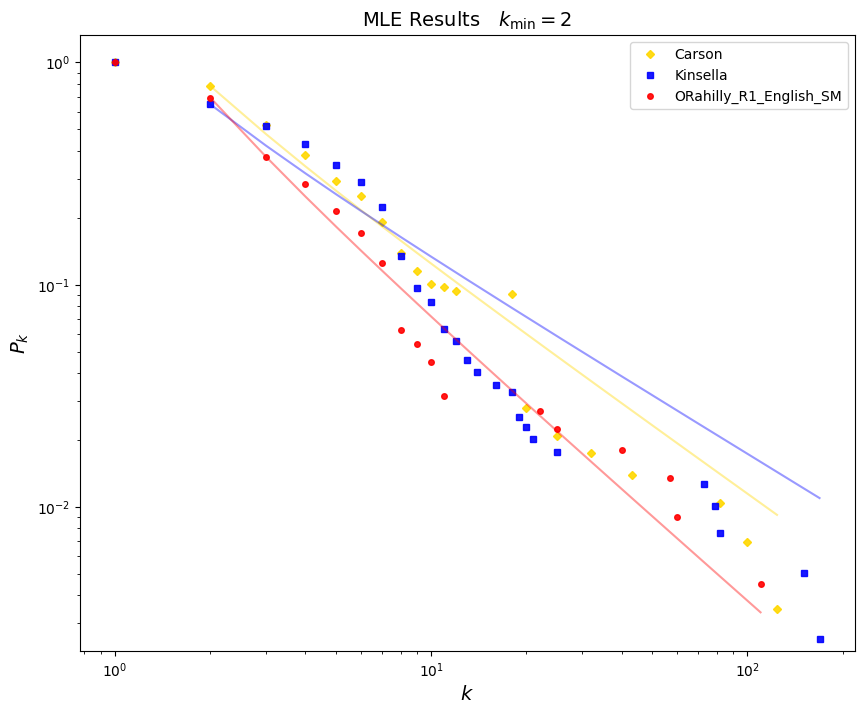

In [ ]:
# for i in graphs:
#   result = fit(i, graphs[i], k_min=2)
#   print('\n==========\n\n')

# g1 = graphs['Táin_ORahilly_edition_Recension2_Book of Leinster_GC 1_nogroups']
# g2 = graphs['TáinORahilly_edition_Recension1_GC_nogroups']
# gaelle_combined = nx.compose(g1,g2)
# fit('combined recensions',gaelle_combined,k_min=2)
subset = {key: graphs[key] for key in ['Carson','Kinsella','ORahilly_R1_English_SM']} # Create a new dictionary containing only the desired graphs
plt.figure(figsize=(10,8))
for i in subset:
  result = fit(i, subset[i],k_min=2)

plt.savefig('mle_powerlaw_output.png', dpi=600)

### MLE Code
https://github.com/Shaneul/MLE/blob/main/MLE_functions.py

In [ ]:
"""
Created on Tue Nov 15 09:46:30 2022

@author: Shane Mannion
Functions for fitting degree distributions to complex networks.
"""

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import zeta
from scipy.special import factorial
from scipy.stats import poisson


def freqTable(G):

    """
    Parameters
    ----------
    G : networkx.graph OR list
        Graph to get freq table of, or degree list of a graph

    Returns
    ----------
    np.array(degree_list): np.ndarray
        array of degrees
    unique_deg: np.ndarray
        array of unique degrees
    table: dict
        freq table of degrees

    """
    if type(G) == nx.classes.graph.Graph:
        degree_dict = dict(G.degree())
        degree_list = list(degree_dict.values())
    else:
        degree_list = G
    degree_list.sort()
    unique_deg = []

    table = {}
    for n in degree_list:
        if n in table:
            table[n] += 1
        else:
            table[n] = 1

    for n in degree_list:
        if n not in unique_deg:
            unique_deg += [n]
    return np.array(degree_list), np.array(unique_deg), table



def degree_list(G):
    """
    Parameters
    ----------

    G : networkx.graph OR list


    Returns
    -------
    np.ndarray
        sorted array of degrees

    """
    if type(G) == nx.classes.graph.Graph:
        degree_dict = dict(G.degree())
        degree_list = list(degree_dict.values())
    else:
        degree_list = G
    degree_list.sort()
    return np.array(degree_list)

def empirical(X_list):
    """
    Takes the MLE result and degree list and returns cumulative probability, unique degrees,
    sequence of integers from kmin to max degree
    Parameters
    ----------
    result : list
        result from MLE function
    X_list : list
        degree list

    Returns
    -------
    params : np.ndarray
        parameters of the distribution
    N : list
        unique degrees of the duistribution
    P : list
        cumulative probability of the degrees
    p : list
        probability values of the

    """
    N,f = np.unique(X_list, return_counts=True)
    cumul = np.cumsum(f[::-1])[::-1]
    p = f/X_list.size
    P = cumul/X_list.size
    return N, P, p


def CCDF(result,X, N, P):
    """
    Uses parameters from the distribution to get the fitted CCDF

    Parameters
    ----------
    result : list
        output from MLE function. [kmin, dist, params, delta]
    Input : list
        The degree list
    P : TYPE
        The empirical CCDF

    Returns
    -------


    """
    k_min = result[0]
    Input = np.unique(X)
    distribution = result[1]
    params = result[2][0]
    C_index = np.where(N == k_min)[0]
    C = P[C_index]
    try:
        inf = np.arange(1000)#np.arange(np.amax(Input))
    except ValueError:
        inf = np.arange(1000)
    if distribution == 'Powerlaw':
        y = C*zeta(params[0], Input)/zeta(params[0], k_min)

    if distribution == 'Exponential':
        y = C*np.exp((-1/params[0])*(Input-k_min))

    if distribution == 'Weibull':
        sum1 = np.array([np.sum((((j+inf)/params[0])**(params[1]-1))*np.exp(-(((j+inf)/params[0])**params[1]))) for j in Input])
        inf_sum = np.sum((((inf + k_min)/params[0])**(params[1]-1))*np.exp(-1*((inf + k_min)/params[0])**params[1]))
        y = C*sum1/inf_sum

    if distribution == 'Lognormal':
        sum1 = np.array([np.sum( (1.0/(j+inf))*np.exp(-((np.log(j+inf)-params[0])**2)/(2*(params[1]**2)))) for j in Input])
        inf_sum = np.sum( (1.0/(inf+k_min)) * np.exp(-((np.log(inf+k_min)-params[0])**2)/(2*params[1]**2) ) )
        y = C*sum1/(inf_sum)

    if distribution == 'Poisson':
        y = 1 - C*poisson.cdf(Input, params[0])

    if distribution == 'Trunc_pl':
        inf_sum = np.sum((inf + k_min)**(-1*params[1]) * np.exp(-1*inf/params[0]))
        z = np.array([np.sum((inf + i)**(-1*params[1]) * np.exp(-1*inf/params[0])) for i in Input])
        y = C*(np.exp(-(Input-k_min)/params[0]))*z/inf_sum

    if distribution == 'Normal':
        norm_n = np.sum( np.exp( -((inf-params[0])**2)/(2*params[1]**2) ))
        sum1 = np.array([np.sum(np.exp(-((j+inf-params[0])**2)/(2*params[1]**2))) for j in Input])
        y = C*sum1/norm_n

    return y



def PDF(result, X, N, p):
    """
    Uses parameters from the distribution to get the fitted PDF

    Parameters
    ----------
    result : list
        output from MLE function. [kmin, dist, params, delta]
    Input : list
        The degree list
    N : list
        unique degree list
    p : list
        The empirical PDF

    Returns
    -------
    y: list
        The PDF of the distribution

    """
    k_min = result[0]
    distribution = result[1]
    Input = np.unique(X)
    params = result[2][0]
    C_index = np.where(N == k_min)[0]
    C = p[C_index]
    try:
        inf = np.arange(np.amax(Input))
    except ValueError:
        inf = np.arange(1000)
    if distribution == 'Powerlaw':
        y = (C/zeta(params[0], k_min))*Input**-params[0]

    if distribution == 'Exponential':
        y = C*( (1-np.exp(-1/params[0]))/np.exp(-k_min/params[0]) )*np.exp(-Input/params[0])

    if distribution == 'Weibull':
        inf_sum = np.sum((((inf + k_min)/params[0])**(params[1]-1))*np.exp(-1*((inf + k_min)/params[0])**params[1]))
        y = C* ((Input/params[0])**(params[1]-1)) * (np.exp((-(Input/params[0])**params[1]))) / inf_sum

    if distribution == 'Lognormal': # Not done
       inf_sum = np.sum( (1.0/(inf+k_min)) * np.exp(-((np.log(inf+k_min)-params[0])**2)/(2*params[1]**2) ) )
       y = C* ( (1/Input) * np.exp(-((np.log(Input)-params[0])**2)/(2*params[1]**2)) ) / inf_sum

    if distribution == 'Poisson': # Not done
        y = 1 - C*poisson.pdf(Input, params[0])

    if distribution == 'Trunc_pl':
        y = C*( (np.exp(-k_min/params[0]))/zeta(params[0], k_min) ) * (Input**(-params[0])) * np.exp(-Input/params[0])

    if distribution == 'Normal':
        norm_n = np.sum( np.exp( -((inf-params[0])**2)/(2*params[1]**2) ))
        y = C* ( np.exp(-((Input-params[0])**2)/(2*params[1]**2)) ) / norm_n

    return y

def CDF(result,X, N, P):
    """
    Uses parameters from the distribution to get the fitted CCDF

    Parameters
    ----------
    result : list
        output from MLE function. [kmin, dist, params, delta]
    Input : list
        The degree list
    P : TYPE
        The empirical CCDF

    Returns
    -------


    """
    k_min = result[0]
    Input = X
    distribution = result[1]
    params = result[2]
    C_index = np.where(N == k_min)[0]
    C = P[C_index]
    try:
        inf = np.arange(np.amax(Input))
    except ValueError:
        inf = np.arange(1000)
    if distribution == 'Powerlaw':
        y = C*zeta(params[0], Input)/zeta(params[0], k_min)

    if distribution == 'Exponential':
        y = C*np.exp((-1/params[0])*(Input-k_min))

    if distribution == 'Weibull':
        sum1 = np.array([np.sum((((j+inf)/params[0])**(params[1]-1))*np.exp(-(((j+inf)/params[0])**params[1]))) for j in Input])
        inf_sum = np.sum((((inf + k_min)/params[0])**(params[1]-1))*np.exp(-1*((inf + k_min)/params[0])**params[1]))
        y = C*sum1/inf_sum

    if distribution == 'Lognormal':
        sum1 = np.array([np.sum( (1.0/(j+inf))*np.exp(-((np.log(j+inf)-params[0])**2)/(2*(params[1]**2)))) for j in Input])
        inf_sum = np.sum( (1.0/(inf+k_min)) * np.exp(-((np.log(inf+k_min)-params[0])**2)/(2*params[1]**2) ) )
        y = C*sum1/(inf_sum)

    if distribution == 'Poisson':
        y = 1 - C*poisson.cdf(Input, params[0])

    if distribution == 'Trunc_pl':
        inf_sum = np.sum((inf + k_min)**(-1*params[1]) * np.exp(-1*inf/params[0]))
        z = np.array([np.sum((inf + i)**(-1*params[1]) * np.exp(-1*inf/params[0])) for i in Input])
        y = C*(np.exp(-(Input-k_min)/params[0]))*z/inf_sum

    if distribution == 'Normal':
        norm_n = np.sum( np.exp( -((inf-params[0])**2)/(2*params[1]**2) ))
        sum1 = np.array([np.sum(np.exp(-((j+inf-params[0])**2)/(2*params[1]**2))) for j in Input])
        y = C*sum1/norm_n

    return 1 - y


def AIC(LnL: float, N:int, params:int = 1):
    """
    AIC with correction for large sample sizes
    Parameters
    ----------
    LnL : float
        log_likelihood value
    params : int, optional
        Number of parameters in the distribution

    Returns
    -------
    float
        AIC for a given log-likelihood and distribution

    """
    if N < 4:
        AIC = -2*LnL + 2*params
    else:
        AIC = -2*LnL + 2*params + ((2*params*(params + 1)))/(N - params - 1)
    return AIC

def BIC(LnL: float, N:int, params:int = 1):
    """
    Parameters
    ----------
    LnL : float
        log_likelihood value
    N : int
        number of nodes with degree > k_min
    params : int, optional
        Number of parameters in the distribution

    Returns
    -------
    float
        BIC for a given log-likelihood and distribution
    """
    return params * np.log(N) - 2*LnL


"""
Log-Likelihood functions: Return negative log-likelihoods for the distributions:
    power-law
    exponential
    weibull
    normal
    stretched exponential
    truncated power-law
    log-normal
    poisson
Parameters
----------
params: np.ndarray
    array of distribution parameters
x: np.ndarray
    array of network degrees above k_min
delta: float
    fraction of degrees below k_min. default = 0
k_min: int
    value from which the distribution is fitted
sum_log: float
    sum of log values of x above
inf: int
    large value to sum to for approximations of infinte sums
lam: float
    lambda parameter for poisson distribution

Returns
-------
NegLnL: float
    Negative of log-likelihood value for given distribution

"""

def powerlaw(params:np.ndarray, x:np.ndarray, sum_log, delta:float = 0, k_min:int = 1):
    NegLnL =  x.size*np.log(zeta(params[0], k_min)) + params[0]*(sum_log)
    return NegLnL

def exp_dist(params:np.ndarray, x:np.ndarray, delta:float=0, k_min:int=1):
    NegLnL = -1 * x.size*(np.log(1-np.exp(-1/params[0]))) + (1/params[0])*(x.sum() - x.size*k_min)
    return NegLnL

def weibull(params, x:np.ndarray, inf, sum_log, delta:float=0, k_min:int=1):
    inf_sum = np.sum((((inf + k_min)/params[0])**(params[1]-1))*np.exp(-1*((inf + k_min)/params[0])**params[1]))
    LnL = -x.size * np.log(inf_sum) - x.size * (params[1] - 1) * np.log(params[0])\
        + (params[1] - 1) * sum_log - np.sum((x/params[0])**params[1])
    NegLnL = -1 * LnL
    return NegLnL

def normal(params, x, inf):
	norm_n = np.sum( np.exp( -((inf-params[0])**2)/(2*params[1]**2) ))
	NegLnL = x.size*np.log(norm_n) + np.sum(((x - params[0])**2)/(2*params[1]**2))
	return NegLnL


def stretched_exp(params,x, inf, k_min):
	norm_s = np.sum( np.exp(-((k_min+inf)/params[0])**params[1] ))
	NegLnL = -1*( -x.size*np.log(norm_s) - np.sum((x/params[0])**params[1]))
	return NegLnL

def trunc_powerlaw(params, x:np.ndarray, inf, delta:float, k_min:int=1):
    inf_sum = np.sum((inf + k_min)**(-1*params[1]) * np.exp(-1*inf/params[0]))
    LnL = x.size * np.log(1 - delta) + x.size * k_min/params[0] - x.size*np.log(inf_sum)\
        - (params[1]*np.log(x) + x/params[0]).sum()
    NegLnL = -1*LnL
    return NegLnL

def logn(params, x, inf, sum_log, k_min=1):
    inf_sum = np.sum( (1.0/(inf+k_min)) * np.exp(-((np.log(inf+k_min)-params[0])**2)/(2*params[1]**2) ) )
    NegLnL = -1*( - x.size*np.log(inf_sum) - sum_log - np.sum( ((np.log(x)-params[0])**2)/(2*params[1]**2) ) )
    return NegLnL

def poisson_dist(lam, x:np.ndarray, delta:float, k_min:int=1):
    m = np.arange(k_min)
    LnL = x.size * np.log(1 - delta) - np.log(1 - np.exp(-1*lam) * np.sum((lam**m)/factorial(m)))\
        - x.size * lam + np.log(lam) * x.sum() - np.sum(np.log(factorial(x)))
    NegLnL = -1*LnL
    return NegLnL

def poisson_large_k(lam, x:np.ndarray):
    d1 = poisson.pmf(x, lam)
    d1 = d1[np.nonzero(d1)]
    NegLnL = -1 * np.sum(np.log(d1))
    return NegLnL


def MLE(X:np.ndarray, k_min:int = 1, vt:int = 3, IC:str = 'AIC'):
    """
    Maximises the log-likelihood for each of the above distributions and chooses the best
    by maximising the AIC weights or minimising the BIC.

    Stopping Criteria: starts with k_min=1 by default and increases by 1 each time.
    Stops when the same distribution is chosen for 2 or 3 consecutive k_min values
    (depending on graph size), returns values obtained at the smallest of these
    k_min values.

    Parameters
    ----------
    X : np.ndarray
        array of degrees of network including below k_min.
    k_min : int, optional, default = 1
        value from which to fit the distribution.
    vt : int, optional, default = 3
        number of votes required to choose a distribution.
    IC : str, optional, default = 'AIC'
        Can be 'AIC', 'BIC'. Which information criteria to use.
    Returns
    -------
    Final_dist : list
        [k_min, fitted distribution name (e.g. powerlaw), array of parameters,
         negative log-likelihood, list of AIC weights]
    Delta : float
        fraction of nodes below final chosen k_min value

    """
    votes = [100,10,100,10,100] # array of numbers to create a standard deviation
                                # greater than 0.1
    Results = {}
    Results['Powerlaw'] = {}
    Results['Exponential'] = {}
    Results['Weibull'] = {}
    Results['Normal'] = {}
    Results['Trunc_PL'] = {}
    Results['Lognormal'] = {}
    Results['Poisson'] = {}
  #  Results['Compound Poisson'] = {}
    stop = False
    while stop == False:#np.std(votes[-vt:]) >= 0.1: # while the last X votes have not been the same
                                      # where X is vt.
        x = X[X >= k_min] # only include degree values over kmin
        delta = (X[X < k_min].size/X.size) # fraction below kmin
        k_mean = x.mean() # mean degree for initial parameter guesses

        try:
            inf = np.arange(np.amax(x) + 1000) # list of numbers for infinite sums required below
        except ValueError:  #raised if x is empty.
            inf = 1000
        sum_log = np.sum(np.log(x))

        opt_pl = minimize(powerlaw, (2), (x, sum_log, delta, k_min), method = 'SLSQP', bounds = [(0.5, 4)])
        Results['Powerlaw'][k_min] = [opt_pl['x'], -1*opt_pl['fun']]

        opt_exp = minimize(exp_dist, (k_mean), (x, delta, k_min), method = 'SLSQP', bounds = ((0.5,k_mean + 20),))
        Results['Exponential'][k_min] = [opt_exp['x'], -1*opt_exp['fun']]

        opt_wb = minimize(weibull, (k_mean,1),(x, inf, sum_log, delta, k_min), method = 'SLSQP', bounds=((0.05, None),(0.05, 4),))
        Results['Weibull'][k_min] = [opt_wb['x'], - 1*opt_wb['fun']]

        opt_normal = minimize(normal, (k_mean, np.std(x)), (x, inf),method='SLSQP',bounds=[(0.,k_mean+10),(0.1,None)])
        Results['Normal'][k_min] = [opt_normal['x'], -1*opt_normal['fun']]

        opt_tpl = minimize(trunc_powerlaw,(k_mean,1),(x, inf, delta, k_min), method = 'SLSQP', bounds=((0.5, k_mean + 20),(0.5,4),))
        Results['Trunc_PL'][k_min] = [opt_tpl['x'], -1*opt_tpl['fun']]
        try: #prevents valueerror when value goes out of bounds given in function
            opt_logn = minimize(logn, (np.log(k_mean), np.log(x).std()), (x, inf, sum_log, k_min), method='TNC',bounds=[(0.,np.log(k_mean)+10),(0.01,np.log(x.std())+10)])
            Results['Lognormal'][k_min] = [opt_logn['x'], -1*opt_logn['fun']]
        except ValueError:
            Results['Lognormal'][k_min] = [[0,0], 10000]
        try:
            poisson_max = np.amax(x)
        except ValueError:
            poisson_max = 1
        if poisson_max > 170: #different method used when k_max is large, due to infinity from factorial
            opt_p = minimize(poisson_large_k, x.mean(), (x), method='SLSQP')
        else:
            opt_p = minimize(poisson_dist, x.mean(), (x, delta, k_min), method='SLSQP', bounds = ((0.5, None),))
        Results['Poisson'][k_min] = [opt_p['x'], -1*opt_p['fun']]
        Distributions = list(Results.keys())

     #   x0 = [k_min*2, x.mean(), x.max()]
     #   opt_cmp = compound_poisson(x, x0)
     #   Results['Compound Poisson'][k_min] = [opt_cmp['x'], -1*opt_p['fun']]

        AICs = []
        BICs = []

        for i in Results.keys():
            if i == 'Lognormal':
                if Results[i][k_min][0][1] == 0:
                    AICs.append(float("inf"))
                    BICs.append(float("inf"))
            if AIC(Results[i][k_min][1], x.size, len(Results[i][k_min][0])) == float("-inf"):
                AICs.append(float("inf"))
            else:
                AICs.append(AIC(Results[i][k_min][1], x.size, len(Results[i][k_min][0])))
            if BIC(Results[i][k_min][1], x.size, len(Results[i][k_min][0])) == float("-inf"):
                BICs.append(float("inf"))
            else:
                BICs.append(BIC(Results[i][k_min][1], x.size, len(Results[i][k_min][0])))
        weights = []
        weight_total = 0
        for i in AICs:
            weight_total += np.exp(-1*(i - np.min(AICs))/2)

        for i in AICs:
            weights += [np.exp(-1*(i - np.min(AICs))/2)/weight_total]

        if IC == 'AIC':
           votes.append(np.argmax(weights).astype(np.int32))

        if IC == 'BIC':
           votes.append(np.argmin(BICs).astype(np.int32))
        #if we only want to fit at a specific k_min, break the loop and return the first result
        if vt == 1:
            Delta = (X[X < k_min]).size/X.size
            Final_dist = [k_min, Distributions[np.argmax(weights)],Results[Distributions[np.argmax(weights)]][k_min], Delta]
            return Final_dist
        if vt > 1:
            if np.std(votes[-vt:]) <= 0.1:
                stop = True
        k_min += 1

    Delta = (X[X < (k_min-vt)]).size/X.size
    Final_dist = [k_min-vt, Distributions[np.argmax(weights)],Results[Distributions[np.argmax(weights)]][k_min-vt], Delta]
    if len(weights) > 0:
        Final_dist.append(weights)
    return Final_dist


def opt_single_dist(X, result, k_min):
    """
    For bootstrapping. Fits only the desired distribution to a boostrapped sample of a
    degree sequence.

    Parameters
    ----------
    X : List
        Degree list.
    result : List
        element of the output from the MLE function.

    Returns
    -------
    Tuple
        optimal parameter values for the given distribution.

    """
    #k_min = result[0]
    x = X[X >= k_min]
    delta = (X[X < k_min].size/X.size)
    k_mean = x.mean()
    try:
        inf = np.arange(np.amax(x)) #Creates a sequence of numbers for infinite sums
    except ValueError:  #raised if x is empty.
        inf = 1000
    sum_log = np.sum(np.log(x))
    if result[1] == 'Powerlaw':
        opt = minimize(powerlaw, (2), (x, sum_log, delta, k_min), method = 'SLSQP', bounds = [(0.5, 4)])

    if result[1] == 'Exponential':
        opt = minimize(exp_dist, (k_mean), (x, delta, k_min), method = 'SLSQP', bounds = ((0.5,k_mean + 20),))

    if result[1] == 'Weibull':
        opt = minimize(weibull, (k_mean,1),(x, inf, sum_log, delta, k_min), method = 'SLSQP', bounds=((0.05, None),(0.05, 4),))

    if result[1] == 'Normal':
        opt = minimize(normal, (k_mean, np.std(x)), (x, inf), method='SLSQP', bounds=[(0.,k_mean+10),(0.1,None)])

    if result[1] == 'Stretched_Exp':
        opt = minimize(stretched_exp,(k_mean,1),(x, inf, k_min), method='SLSQP',bounds=[(0.5,None),(0.05,4.)])

    if result[1] == 'Trunc_PL':
        opt = minimize(trunc_powerlaw,(k_mean,1),(x, inf, delta, k_min), method = 'SLSQP', bounds=((0.5, k_mean + 20),(0.5,4),))

    if result[1] == 'Lognormal':
        try: #prevents valueerror when value goes out of bounds given in function
            opt = minimize(logn, (np.log(k_mean), np.log(x).std()), (x, inf, sum_log, k_min),
                           method='TNC',bounds=[(0.,np.log(k_mean)+10),(0.01,np.log(x.std())+10)])
        except ValueError:
            return [0,0]
    if result[1] == 'Poisson':
        try:
            poisson_max = np.amax(x)
        except ValueError:
            poisson_max = 1
        if poisson_max > 170: #different method used when k_max is large, due to infinity from factorial
            opt = minimize(poisson_large_k, x.mean(), (x), method='SLSQP')
        else:
            opt = minimize(poisson_dist, x.mean(), (x, delta, k_min), method='SLSQP', bounds = ((0.5, None),))
    return opt['x']


# def plotting(N, Input, fit, result, emp, dist, Name = '', save=False, saveloc=''):
#     """

#     Parameters
#     ----------
#     N : list
#         Unique degree list for the graph.

#     Input : list
#         Complete list of integers from k_min to k_max. For plotting the fitted
#         curve.
#     fit : list
#         List of fitted p_k or P_k values for plotting the fitted curve.
#     Name : string
#         Name of graph. For plot label. The default is a blank string.
#     result : list
#         Result from MLE function output. For labelling fitted curve
#     emp : list
#         List of empirical p_k or P_k values for plotting.
#     dist : string
#         Can be 'PDF' or 'CCDF'. Which distribution function to plot.
#     save : Boolean, optional
#         If plots are to be saved. The default is False. Default image resolution
#         iis 300 dpi. If True, saveloc must be provided.
#     saveloc : string
#         Location to save plot. Only required if save == True.
#     Returns
#     -------
#     None.

#     """

#     plt.step(N, emp, '+', ms = 4, color = 'k', label = 'Actual')
#     plt.plot(Input, fit, label = result[1])
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.xlabel('$k$', color = 'k', fontsize = 14)
#     plt.ylim(ymin=0.5*np.min(emp))
#     if dist == 'PDF':
#         plt.ylabel(r'$p_k$', fontsize = 14)
#     if dist == 'CCDF':
#         plt.ylabel(r'$P_k$', fontsize = 14)
#     plt.title(Name + ' ' + ' ' + r'$k_{\rm min} = $'  + str(result[0]), fontsize=14)
#     plt.legend()
#     if save == True:
#         if saveloc == None:
#             raise ValueError
#             'save is True but no save location provided. Please enter a folder path to save plot to'
#             #raises an error if save is true but no filepath is provided.
#         else:
#             plt.savefig(saveloc + Name + ' ' + dist, dpi=300)
#     plt.show()

#Plotting function has been altered to generate a single output plot which contains all of the data
def plotting(N, Input, fit, result, emp, dist, Name = '', save=False, saveloc=''):
  import random
  seed = random.randint(1, 1000)
  random.seed(seed)
  shapes = ['o', 's', '^', 'D', 'v', '*', 'x', 'P', 'H']
  random_shape = random.choice(shapes)
  colours = ['red', 'blue', 'green', 'orange', 'purple','brown', 'pink', 'gray', 'olive', 'cyan','magenta', 'yellow', 'black', 'teal', 'gold']
  random_colour = random.choice(colours)

  plt.step(N, emp, random_shape, ms = 4, label = Name, alpha=0.7, color=random_colour) #color='k'
  plt.plot(Input, fit, alpha=0.6, color=random_colour) #label = result[1]+' '+Name
  plt.xscale('log')
  plt.yscale('log')
  plt.xlabel('$k$', color = 'k', fontsize = 14)
  plt.ylim(ymin=0.5*np.min(emp))
  if dist == 'PDF':
    plt.ylabel(r'$p_k$', fontsize = 14)
  if dist == 'CCDF':
    plt.ylabel(r'$P_k$', fontsize = 14)
  plt.title('MLE Results   ' + r'$k_{\rm min} = $'  + str(result[0]), fontsize=14)
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

  if save == True:
    if saveloc == None:
      raise ValueError
      'save is True but no save location provided. Please enter a folder path to save plot to'
      #raises an error if save is true but no filepath is provided.
    else:
      plt.savefig(saveloc + Name + ' ' + dist, dpi=300)
  #plt.show()




def bootstrap(G_list, result):

    """
    Bootstraps a sample of data and using the established k_min and distribution
    Obtains 1,000 values for the parameter(s) of the distribution.

    Parameters
    ----------
    G_list : list or np.array
        Degree list
    result : list
        element of the output from the MLE function.

    Returns
    -------
    parameters : list of list
        list of lists. Each list is the values for
        one of the parameters of a distribution fit to bootstrapped samples.

    """

    params1 = []
    params2 = []
    while len(params1) < 1000:
        sample = np.array(np.random.choice(G_list, len(G_list), replace=True))
        opt = opt_single_dist(sample, result, result[0])
        if len(opt) == 1: # if it is a one parameter distribution
            if np.isnan(opt[0]) == False: # we only count non-nan parameter values
                params1.append(opt[0])

        if len(opt) == 2:
            if np.isnan(opt[0]) == False & np.isnan(opt[1]) == False:
                params1.append(opt[0])
                params2.append(opt[1])


    if len(params2) == 0: # graph has one distribution
    	parameters = [params1]
    else:
        parameters = [params1, params2]

    return parameters



def summary_stats(Name, result, params):
    """
    Takes bootstrapping results and gets summary statistics for them.

    Parameters
    ----------
    Name : string
        Name of the dataset
    result : list
        output from MLE or fit function
    params : list
        list of lists. Each element is list of values for each parameter of
        the fitted distribution.

    Returns
    -------
    row : list
        Summary of the bootstrapping results.

    """
    means = []
    devs = []
    perc1 = []
    perc2 = []
    for i in params:
        means.append(np.round(np.mean(i), 2))
        devs.append(np.round(np.std(i), 2))
        perc1.append(np.round(np.percentile(i, 2.5), 2))
        perc2.append(np.round(np.percentile(i, 97.5), 2))

    row = [Name, result[1], result[0], result[2][0][0], means[0], devs[0], perc1[0], perc2[0]]
    if len(result[2][0]) == 2:
        row.extend([result[2][0][1], means[1], devs[1], perc1[1], perc2[1]])
    return row


def fit(Name, G, k_min:int=1, vt=None, plot_type='auto', save=False, saveloc=None, IC='AIC'):
    """
    Parameters
    ----------
    Name : String
        Network/file name for results
    G : array-like
        degree list
    k_min : int, optional
        Initial k_min value. The default is 1.
    vt : int, optional
        Number of times a distribution must be chosen before it is returned
        as the correct one. If None, chosen automatically.
    plot_type : String: 'auto','pdf', 'ccdf', 'both', 'none', optional
        Determines what plots the code will generate. Default is 'auto'.
    save : Boolean.
        True if the plots are to be saved. The default is False
    saveloc : String
        filepath for location to save plots. Only required if save is True
        The default is None.
    IC : String : 'AIC' or 'BIC'
        Which information criteria to use. The default is AIC
    Returns
    -------
    result : list
        List [kmin, distribution name, parameters, Delta]

    """

    X = degree_list(G) # Get the degree list
    if len(X) < 2500:
        if vt == None:
            vt = 2 # for small datasets we need fewer consecutive votes to
                  # determine the distribution
        if plot_type == 'auto':
            plot_type = 'ccdf' # for small datasets we do not want to display the PDF
    else:
        if vt == None:
            vt = 3
        if plot_type == 'auto':
            plot_type = 'both' # for larger datasets we display both PDF and
                               # CCDF

    result = MLE(X, k_min, vt, IC) # Perform the MLE using kmin=1 as default
    N, P, p = empirical(X)	# Get the unique degree list, empirical CCDF and
                            # PDF values

    Input = np.arange(result[0],np.amax(X)+1) # generate complete list of integers
                                              # kmin to kmax


    if plot_type == 'both' or plot_type == 'pdf':
        pdf = PDF(result, Input, N, P)
        plotting(N,Input, pdf, result, p, 'PDF', Name, save, saveloc)
    if plot_type == 'both' or plot_type == 'ccdf':
        ccdf = CCDF(result, Input, N, P)
        plotting(N,Input, ccdf, result, P, 'CCDF', Name, save, saveloc)

    print('For k greater than or equal to', result[0], 'the degree distribution follows a',
          result[1], 'distribution with parameters', np.round(result[2][0],2))

    return result

### Run MLE Code
https://github.com/Shaneul/MLE/blob/main/MLE_functions.py

Carson


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/tmp/ipython-input-4-2793973124.py:397: RuntimeWarning: divide by zero encountered in log
  NegLnL = -1*( - x.size*np.log(inf_sum) - sum_log - np.sum( ((np.log(x)-params[0])**2)/(2*params[1]**2) ) )
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


For k greater than or equal to 2 the degree distribution follows a Weibull distribution with parameters [0.05 0.29]



Kinsella


/tmp/ipython-input-4-2793973124.py:372: RuntimeWarning: divide by zero encountered in log
  LnL = -x.size * np.log(inf_sum) - x.size * (params[1] - 1) * np.log(params[0])\


For k greater than or equal to 5 the degree distribution follows a Powerlaw distribution with parameters [2.64]



ORahilly_R1_English_GC
For k greater than or equal to 3 the degree distribution follows a Powerlaw distribution with parameters [2.28]



For k greater than or equal to 4 the degree distribution follows a Powerlaw distribution with parameters [2.41]


[4,
 'Powerlaw',
 [array([2.41123892]), np.float64(-324.20621469773937)],
 0.6132075471698113,
 [np.float64(0.9328949084518008),
  np.float64(1.3013077475860954e-13),
  np.float64(0.0671050901425131),
  np.float64(1.460388015468321e-46),
  np.float64(3.1876567012864225e-52),
  np.float64(1.4055559948244341e-09),
  np.float64(4.295623767505673e-257)]]

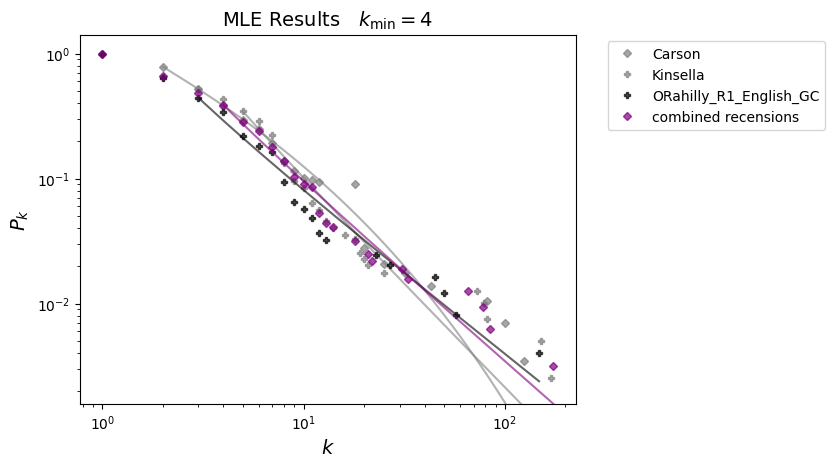

In [ ]:
subset = {key: graphs[key] for key in ['Carson','Kinsella','ORahilly_R1_English_GC']} # Create a new dictionary containing only the desired graphs
for i in subset:
  print(i)
  result = fit(i, subset[i],k_min=2)
  print('\n==========\n\n')

g1 = graphs['ORahilly_R1_Irish']
g2 = graphs['ORahilly_R2_Irish']
gaelle_combined = nx.compose(g1,g2)
fit('combined recensions',gaelle_combined,k_min=2)

### Truncation/IM&KS values

In [ ]:
def remove_nodes(G,N_min):
  # Randomly selects nodes to remove
  # 'random.sample()' selects a random subset of nodes from the graph
  # The number of nodes to remove is the difference between the current nuber of nodes and the target size 'N_min'
  remove = random.sample(list(G.nodes()),len(G.nodes())-N_min) # Randomly selects nodes to be removed

  # Create a copy of the original graph to preserce the original network (G)
  G_new = G.copy() # Makes a copy of the graph, so the changes made do not affect the original network

  # Remove the selected nodes from the copied graph
  G_new.remove_nodes_from(remove) # Remove all the nodes selected in the 'remove' list

  # Return thenew graph with the desired number of nodes
  return G_new # The graph with the truncated node set is returned
def calculate_properties(G):
  # Calculate the number of nodes (N)
  N = G.number_of_nodes()

  # Calculate the number of edges (L)
  L = G.number_of_edges()

  # List stores the degrees of each node
  degs = []
  for (node,value) in G.degree():
    degs.append(value)
  totdeg = sum(degs)
  # Calculate the average degree (<k>)
  k_avg = round(totdeg/N,3)

  # List stores squared difference between each node's degree and the average
  degdiff = []
  for i in degs:
    degdiff.append((i-k_avg)**2)
  # Calculates the variance of degrees (<k^2>)
  k_delta = round(sum(degdiff)/N,3)

  # Calculates the assortativity (r)
  r = round(nx.degree_assortativity_coefficient(G),3)

  # Calculates the clustering coefficient (C)
  C = round(nx.average_clustering(G),3)

  # If the network is not connected
  if nx.is_connected(G) == False:
    # List stores average shortest path length
    avgpaths = []
    # Iterate over all connected nodes
    for g in nx.connected_components(G):
      # Create subgraph for all connected components
      subgraphs = G.subgraph(g)
      # Average shortest path for the subgraphs
      avgpaths.append(nx.average_shortest_path_length(subgraphs))
      # Calculates average path length (l_avg)
      l_avg = round(max(avgpaths),3)
  else:
    # Calculates average path length (l_avg)
    l_avg = round(nx.average_shortest_path_length(G),3)

  # Constant for the expetcted path length in random networks
  EM = 0.5772

  # Calculate the average pth length of a random network of the same size (l_rand)
  lrand = round(0.5 + (np.log(N)-EM)/np.log(k_avg),5)

  # Calculate the clustering coefficienct of a random network of the same size (C_rand)
  Crand = round(k_avg/(N-1),5)

  # Return all the calculated properties as a tuple
  return N, L, k_avg, k_delta, r, C, Crand, l_avg, lrand
def avg_properties(properties_list):
  # Initialise an empty dictionary to store the averag values of the properties
  average_properties = {}

  # Iterate over the index of each property in the tuple
  for i in range(len(properties_list[0])): # len(properties_list[0]) gives the number of properties in each tuple
      # For each property index 'i', calculate the average value across all networks in the list
      average_properties[i] = np.mean([prop[i] for prop in properties_list]) # Access tuple elements by index

  # Return the dictionary containing the average property
  return average_properties
def compare_networks(G1,G2,reps=100):
  # Initialise an empty list to store the properties of the random subgraphs from G2
  rand_properties = []

  # Perform 'reps' number of repeated comparisons
  for i in range(reps):
    # Randomly remove nodes from G2 to create a new subgraph with the same size as G1
    G_new = remove_nodes(G2,size) # remove_nodes function creates subgraph of size 'size'

    # Calculate the properties of the new subgraph (G_new)
    properties = calculate_properties(G_new)

    # Append the properties of the subgraph to the 'rand_properties' list
    rand_properties.append(properties)

  # Calculate the average properties of the random subgraphs (mean of all repititions)
  mean_properties = avg_properties(rand_properties)

  # Calculate the properties of the original smaller network (G1)
  small_properties = calculate_properties(G1) # Calculte network properties for the smaller network
  return small_properties, mean_properties
def Hamming(G1,G2,weight=None):
    """
    === Description ===
    Hamming distance
    This is just the sum of difference of the two adjacency matrices
    Note: This requires both networks being the same size

    === Parameters ===
    G1, G2 : networkx graph object
        Networks to compare
    weight : array like (optional, default: None)
        Name of the networkx weight property if assigned to the edges

    === Returns ===
    Hamming distance : float
        The Hamming distance between the two graphs
    """
    a_i = nx.adjacency_matrix(G1,weight=weight)
    a_j = nx.adjacency_matrix(G2,weight=weight)
    N = len(G1)
    return np.absolute((a_i-a_j)).sum()/(N*(N-1))

def IM_dist(G1,G2,gamma,weight=None):
    """
    === Description ===
    Ipsen-Mikhailov distance
    This function first takes the Laplacian spectrum (i.e. the eignevectors of the Laplacian)
    The distance is obtained from the intergal of the difference of the Lorentz functions.
      *** I am uncertain as to how the weight affects this, CHECK!!! ***

    === Parameters ===
    G1, G2 : networkx graph object
        Networks to compare
    gamma : float
        The parameter gamma for the Lorentz function (see following function)
    weight : array like (optional, default: None)
        Name of the networkx weight property if assigned to the edges

    === Returns ===
    IM distance : float
        The Ipsen-Mikhailov distance between the two graphs
    """
    L_g = nx.laplacian_spectrum(G1, weight=weight)
    L_h = nx.laplacian_spectrum(G2, weight=weight)
    L_g[L_g< 1e-10]=0
    L_h[L_h< 1e-10]=0
    omega_g = np.sqrt(L_g)
    omega_h = np.sqrt(L_h)

    lorentz = lambda w,gamma,omega: (gamma / ((w-omega)**2 + gamma**2)).sum()

    #These are the normalisation values for the Lorentz function of each graph
    K_g,err = integrate.quad(lorentz,0,np.inf,args=(gamma,omega_g,), limit=500)
    K_h,err = integrate.quad(lorentz,0,np.inf,args=(gamma,omega_h,), limit=500)
    K_g = 1/K_g
    K_h = 1/K_h

    d = lambda w: (K_g*lorentz(w,gamma,omega_g) - K_h*lorentz(w,gamma,omega_h))**2

    dist,err = integrate.quad(d,0,np.inf,limit=500)

    return np.sqrt(dist)

def gamma(G1,G2,n_decimal=2,lower=0.1,upper=0.7):
    """
    === Description ===
    gamma of Lorentz distributions
    This function calculates the gamma parameter for a complete and empty network of
    the same size. Note the choice of the larger one to be empty to reduce computation time
    It takes a value from 0 to 1.
      *** TO DO: Put in a break so that it stops sweeping for gamma after a local extrama close to 1 ***

    === Parameters ===
    G1, G2 : networkx graph object
        Networks to compare
    n_decimal : int (optional, default: 2)
        The number of decimal places we want gamma, it doesn't need to be particularly high
    lower : float (optional, default: 0.1)
        The lower bound for where we want to begin looking for gamma
    upper : float (optional, default: 0.7)
        The upper bound for where we stop looking for an optimal gamma

    === Returns ===
    gam : float
    """
    n1, n2 = len(G1), len(G2)
    if n1 <= n2:
        F = nx.complete_graph(n1)
        E = nx.empty_graph(n2)
    else:
        F = nx.complete_graph(n2)
        E = nx.empty_graph(n1)

    s = '.'
    for i in range(n_decimal):
        s += '9'

    for gam in range(int(lower*(10**n_decimal)),int(upper*(10**n_decimal))):
        gam = gam/(10**n_decimal)
        d = IM_dist(F,E,gam)
        if round(d,n_decimal) == float(s):
            break
    return gam

def HIM(G1,G2,epsilon=1, IM=False):
    H = Hamming(G1,G2)
    if IM is False:
        IM = IM_dist(G1,G2, gamma(G1,G2))
    return (1/np.sqrt(1+epsilon)) * (np.sqrt(H**2 + epsilon*IM**2))

def further_comparison(G1,G2):
  '''
  === Description ===
  Compares the network properties of a smaller network (G1) to a larger network (G2) by
  truncating the larger network to the size of the smaller network.

  === Parameters ===
  G1 (graph object): Smaller Network
  G2 (graph object): Larger Network

  === Returns ===
  small_properties (dict): Dictionary containing the properties of the smaller network
  mean_properties (dict): Dictionary containing the average properties of the larger network
  '''

  # Ensure G1 is the smaller network
  if len(G1) > len(G2):
    G1, G2 = G2, G1  # Swap G1 and G2 if G1 is larger

  # Determine the target size for truncation based on the size of the smaller network (G1)
  size = len(G1) # Number of nodes in the smaller network
  reps = 100 # Number of repititions for creating truncated networks from G2

  # === Pre-Truncation Comparison
  print('\n\nPre-Truncation Values\n')
  print('Smaller Network', '\n')
  for i in range(9):
    print(calculate_properties(G1)[i])
  print('\nLarger Network', '\n')
  for i in range(9):
    print(calculate_properties(G2)[i])

  # Create a table to display similarity metrics between the small (G1) and large (G2) networks
  gam = gamma(G1,G2,n_decimal=1)
  print('\n\nPre Truncation Comparison (KS&IM)\n')
  print('IM Distance:\t\t', IM_dist(G1,G2,gam))
  print('KS Statistic:\t\t', scipy.stats.ks_2samp(G1,G2)[0])
  print('KS p-value:\t\t', scipy.stats.ks_2samp(G1,G2)[1])

  # === Post-Truncatin Comparison ===
  # Initialise lists to store metrics acoss multiple truncated subgraphs
  rand_properties = []
  Gamma_post = []
  IM_post = []
  KS_stat_post = []
  KS_pvalue_post = []

  # Generate random subgraphs of G2 and calculate the comparison metrics
  for i in range(reps):
    G_new = remove_nodes(G2,size) # Create a truncated subgraph of the larger network (G2)
    properties = calculate_properties(G_new) # Calculate the properties of the truncated network
    Gamma_post.append(gamma(G1,G_new,n_decimal=1)) # Calculate gamma
    IM_post.append(IM_dist(G1,G_new,gam)) # Calculate IM distance
    KS_stat_post.append(scipy.stats.ks_2samp(G1,G_new)[0]) # KS statistic
    KS_pvalue_post.append(scipy.stats.ks_2samp(G1,G_new)[1]) #KS p-value
    rand_properties.append(properties) # Add properties to the list
    # print('Loading...', i, '%') # Progress indicator, code takes ~15mins to run for 100 repititions

  # Calculate average properties and metrics for the truncated subgraphs
  mean_properties = avg_properties(rand_properties) # Average properties of truncated subgraphs
  small_properties = calculate_properties(G1) # Properties of the smaller network
  Gamma_avg = np.mean(Gamma_post) # Average gamma
  IM_avg = np.mean(IM_post) # Average IM distance
  KS_stat_avg = np.mean(KS_stat_post) # Average KS statistic
  KS_pvalue_avg = np.mean(KS_pvalue_post) # Average KS p-value

  # Create a table to display similarity metrics between the small (G1) and large (G2) networks
  gam = gamma(G1,G2,n_decimal=1)
  print('\n\n\nPost Truncation Comparison (KS&IM)\n')
  print('IM Distance:\t\t', IM_avg)
  print('KS Statistic:\t\t', KS_stat_avg)
  print('KS p-value:\t\t', KS_pvalue_avg)

  # Return the properties of the smaller network and the average properties of the truncated subgraphs
  return small_properties, mean_properties

### Run IM/KS truncation code

In [ ]:
k = graphs['Kinsella']
k_np = graphs['Kinsella_NoPretales']
ore1_g = graphs['ORahilly_R1_English_GC']
ori1 = graphs['ORahilly_R1_Irish']
ori2 = graphs['ORahilly_R2_Irish']
ori12 = nx.compose(ori1,ori2)
car = graphs['carson']

# print('----- KINSELLA COMPARISONS -----\n\n')
# G1 = k
# G2s = [k_np, ore1_g, ori1, ori2, ori12, car]
# for G2 in G2s:
#   print('\n', '-------','\n',G2,'\n', '-------','\n')
#   if len(G1) < len(G2):  # Switch roles if G2 is larger than G1
#     print("Kinsella is smaller")
#     small_props, avg_props = further_comparison(G1, G2)
#   else:
#     print("Kinsella is larger")
#     small_props, avg_props = further_comparison(G2, G1)
#   print('\nSmaller Network Properties\n')
#   for i in small_props:
#     print(i)
#   print('\n')
#   print('\nAverage Truncated Networks Porperties\n')
#   for key in avg_props:
#     print(avg_props[key])
#   print('\n\n==================\n==================\n=================\n\n')


# print('----- KINSELLA NO PRETALES COMPARISONS -----\n\n')
# G1 = k_np
# G2s = [ore1_g, ori1, ori2, ori12, car]
# for G2 in G2s:
#   print('\n', '-------','\n',G2,'\n', '-------','\n')
#   # Check lengths of G1 and G2 and switch if necessary
#   if len(G1) < len(G2):  # Switch roles if G2 is larger than G1
#     print("Kinsella no pretales is smaller")
#     small_props, avg_props = further_comparison(G1, G2)
#   else:
#     print("Kinsella no pretales is larger")
#     small_props, avg_props = further_comparison(G2, G1)
#   print('Smaller Network Properties')
#   for i in small_props:
#     print(i)
#   print('\n')
#   print('Average Truncated Networks Porperties')
#   for key in avg_props:
#     print(avg_props[key])
#   print('\n\n==================\n==================\n=================\n\n')


# print('----- ORAHILLY R1 ENGLISH (GAELLE) COMPARISONS -----\n\n')
# G1 = ore1_g
# G2s = [ori1, ori2, ori12, car]
# for G2 in G2s:
#   print('\n', '-------','\n',G2,'\n', '-------','\n')
#   # Check lengths of G1 and G2 and switch if necessary
#   if len(G1) < len(G2):  # Switch roles if G2 is larger than G1
#     print("ORahilly R1 English (Gaelle) is smaller")
#     small_props, avg_props = further_comparison(G1, G2)
#   else:
#     print("ORahilly R1 English (Gaelle) is larger")
#     small_props, avg_props = further_comparison(G2, G1)
#   print('Smaller Network Properties')
#   for i in small_props:
#     print(i)
#   print('\n')
#   print('Average Truncated Networks Porperties')
#   for key in avg_props:
#     print(avg_props[key])
#   print('\n\n==================\n==================\n=================\n\n')


# print('----- ORAHILLY R1 IRISH (GAELLE) COMPARISONS -----\n\n')
# G1 = ori1
# G2s = [ori2, ori12, car]
# for G2 in G2s:
#   print('\n', '-------','\n',G2,'\n', '-------','\n')
#   # Check lengths of G1 and G2 and switch if necessary
#   if len(G1) < len(G2):  # Switch roles if G2 is larger than G1
#     print("ORahilly R1 Irish (Gaelle) is smaller")
#     small_props, avg_props = further_comparison(G1, G2)
#   else:
#     print("ORahilly R1 Irish (Gaelle) is larger")
#     small_props, avg_props = further_comparison(G2, G1)
#   print('Smaller Network Properties')
#   for i in small_props:
#     print(i)
#   print('\n')
#   print('Average Truncated Networks Porperties')
#   for key in avg_props:
#     print(avg_props[key])
#   print('\n\n==================\n==================\n=================\n\n')

print('----- ORAHILLY R2 IRISH (GAELLE) COMPARISONS -----\n\n')
G1 = ori2
G2s = [ori12, car]
for G2 in G2s:
  print('\n', '-------','\n',G2,'\n', '-------','\n')
  # Check lengths of G1 and G2 and switch if necessary
  if len(G1) < len(G2):  # Switch roles if G2 is larger than G1
    print("ORahilly R2 Irish (Gaelle) is smaller")
    small_props, avg_props = further_comparison(G1, G2)
  else:
    print("ORahilly R2 Irish (Gaelle) is larger")
    small_props, avg_props = further_comparison(G2, G1)
  print('Smaller Network Properties')
  for i in small_props:
    print(i)
  print('\n')
  print('Average Truncated Networks Porperties')
  for key in avg_props:
    print(avg_props[key])
  print('\n\n==================\n==================\n=================\n\n')

print('----- ORAHILLY R1+R2 IRISH (GAELLE) COMPARISONS -----\n\n')
G1 = ori12
G2s = [car]
for G2 in G2s:
  print('\n', '-------','\n',G2,'\n', '-------','\n')
  # Check lengths of G1 and G2 and switch if necessary
  if len(G1) < len(G2):  # Switch roles if G2 is larger than G1
    print("ORahilly R1+R2 Irish (Gaelle) is smaller")
    small_props, avg_props = further_comparison(G1, G2)
  else:
    print("ORahilly R1+R2 Irish (Gaelle) is larger")
    small_props, avg_props = further_comparison(G2, G1)
  print('Smaller Network Properties')
  for i in small_props:
    print(i)
  print('\n')
  print('Average Truncated Networks Porperties')
  for key in avg_props:
    print(avg_props[key])
  print('\n\n==================\n==================\n=================\n\n')

KeyError: 'kinsella'

### Graph edit distance

In [ ]:
def compute_ged(gt_pred, gt_graph):
    from gklearn.ged.env import GEDEnv
    ged_env = GEDEnv() # initailize GED environment.
    ged_env.set_edit_cost('CONSTANT', # GED cost type.
                          edit_cost_constants=[1, 1, 1, 1, 1, 1] # edit costs.
                          )

    ged_env.add_nx_graph(gt_pred, '') # add graph1
    ged_env.add_nx_graph(gt_graph, '') # add graph2
    listID = ged_env.get_all_graph_ids() # get list IDs of graphs
    ged_env.init(init_type='LAZY_WITH_SHUFFLED_COPIES') # initialize GED environment.
    options = {'initialization_method': 'RANDOM', # or 'NODE', etc.
               'threads': 1 # parallel threads.
               }
    ged_env.set_method('BIPARTITE', # GED method.
                       options # options for GED method.
                       )
    ged_env.init_method() # initialize GED method.

    ged_env.run_method(listID[0], listID[1]) # run.

##    pi_forward = ged_env.get_forward_map(listID[0], listID[1]) # forward map.
##    pi_backward = ged_env.get_backward_map(listID[0], listID[1]) # backward map.
    dis = ged_env.get_upper_bound(listID[0], listID[1])	# GED bewteen two graphs.
    return dis

### Run Graph Edit Distance code

In [ ]:
k = graphs['Kinsella']
k_np = graphs['Kinsella_NoPretales']
ore1_me = graphs['ORahilly_R1_English_SM']
ore1_g = graphs['ORahilly_R1_English_GC']
ori1 = graphs['ORahilly_R1_Irish']
ori2 = graphs['ORahilly_R2_Irish']
ori12 = nx.compose(ori1,ori2)
car = graphs['Carson']

print('----- KINSELLA COMPARISONS -----\n\n')
g1 = k
g2s = [k_np, ore1_me, ore1_g, ori1, ori2, ori12, car]
for g2 in g2s:
  g1.remove_edges_from(nx.selfloop_edges(g1)) # make sure self loops are gone
  g1.remove_nodes_from(list(nx.isolates(g1))) # make sure deg = 0 nodes are gone
  g2.remove_edges_from(nx.selfloop_edges(g2)) # make sure self loops are gone
  g2.remove_nodes_from(list(nx.isolates(g2))) # make sure deg = 0 nodes are gone
  #x = compute_ged(nx.complete_graph(max([len(g1),len(g2)])), nx.empty_graph(min([len(g1),len(g2)])))
  y = len(nx.complete_graph(max([len(g1),len(g2)])).edges())+max([len(g1),len(g2)])-min([len(g1),len(g2)])
  #print('GED upper limit v1: \t\t\t\t\t', x)
  print('GED upper limit v2: \t\t\t\t\t', y)
  GED = compute_ged(g1,g2)
  print('GED: \t\t\t\t\t', GED)
  normalised_GED = GED/y
  print('Normalised GED: \t\t\t\t\t', normalised_GED)
  print('\n\n')

print('----- KINSELLA NO PRETALES COMPARISONS -----\n\n')
g1 = k_np
g2s = [ore1_me, ore1_g, ori1, ori2, ori12, car]
for g2 in g2s:
  #x = compute_ged(nx.complete_graph(max([len(g1),len(g2)])), nx.empty_graph(min([len(g1),len(g2)])))
  y = len(nx.complete_graph(max([len(g1),len(g2)])).edges())+max([len(g1),len(g2)])-min([len(g1),len(g2)])
  #print('GED upper limit v1: \t\t\t\t\t', x)
  print('GED upper limit v2: \t\t\t\t\t', y)
  GED = compute_ged(g1,g2)
  print('GED: \t\t\t\t\t', GED)
  normalised_GED = GED/y
  print('Normalised GED: \t\t\t\t\t', normalised_GED)
  print('\n\n')

print('----- ORAHILLY R1 ENGLISH (ME) COMPARISONS -----\n\n')
g1 = ore1_me
g2s = [ore1_g, ori1, ori2, ori12, car]
for g2 in g2s:
  #x = compute_ged(nx.complete_graph(max([len(g1),len(g2)])), nx.empty_graph(min([len(g1),len(g2)])))
  y = len(nx.complete_graph(max([len(g1),len(g2)])).edges())+max([len(g1),len(g2)])-min([len(g1),len(g2)])
  #print('GED upper limit v1: \t\t\t\t\t', x)
  print('GED upper limit v2: \t\t\t\t\t', y)
  GED = compute_ged(g1,g2)
  print('GED: \t\t\t\t\t', GED)
  normalised_GED = GED/y
  print('Normalised GED: \t\t\t\t\t', normalised_GED)
  print('\n\n')


print('----- ORAHILLY R1 ENGLISH (GAELLE) COMPARISONS -----\n\n')
g1 = ore1_g
g2s = [ori1, ori2, ori12, car]
for g2 in g2s:
  #x = compute_ged(nx.complete_graph(max([len(g1),len(g2)])), nx.empty_graph(min([len(g1),len(g2)])))
  y = len(nx.complete_graph(max([len(g1),len(g2)])).edges())+max([len(g1),len(g2)])-min([len(g1),len(g2)])
  #print('GED upper limit v1: \t\t\t\t\t', x)
  print('GED upper limit v2: \t\t\t\t\t', y)
  GED = compute_ged(g1,g2)
  print('GED: \t\t\t\t\t', GED)
  normalised_GED = GED/y
  print('Normalised GED: \t\t\t\t\t', normalised_GED)
  print('\n\n')


print('----- ORAHILLY R1 IRISH (GAELLE) COMPARISONS -----\n\n')
g1 = ori1
g2s = [ori2, ori12, car]
for g2 in g2s:
  #x = compute_ged(nx.complete_graph(max([len(g1),len(g2)])), nx.empty_graph(min([len(g1),len(g2)])))
  y = len(nx.complete_graph(max([len(g1),len(g2)])).edges())+max([len(g1),len(g2)])-min([len(g1),len(g2)])
  #print('GED upper limit v1: \t\t\t\t\t', x)
  print('GED upper limit v2: \t\t\t\t\t', y)
  GED = compute_ged(g1,g2)
  print('GED: \t\t\t\t\t', GED)
  normalised_GED = GED/y
  print('Normalised GED: \t\t\t\t\t', normalised_GED)
  print('\n\n')

print('----- ORAHILLY R2 IRISH (GAELLE) COMPARISONS -----\n\n')
g1 = ori2
g2s = [ori12, car]
for g2 in g2s:
  #x = compute_ged(nx.complete_graph(max([len(g1),len(g2)])), nx.empty_graph(min([len(g1),len(g2)])))
  y = len(nx.complete_graph(max([len(g1),len(g2)])).edges())+max([len(g1),len(g2)])-min([len(g1),len(g2)])
  #print('GED upper limit v1: \t\t\t\t\t', x)
  print('GED upper limit v2: \t\t\t\t\t', y)
  GED = compute_ged(g1,g2)
  print('GED: \t\t\t\t\t', GED)
  normalised_GED = GED/y
  print('Normalised GED: \t\t\t\t\t', normalised_GED)
  print('\n\n')

print('----- ORAHILLY R1+R2 IRISH (GAELLE) COMPARISONS -----\n\n')
g1 = ori12
g2s = [car]
for g2 in g2s:
  #x = compute_ged(nx.complete_graph(max([len(g1),len(g2)])), nx.empty_graph(min([len(g1),len(g2)])))
  y = len(nx.complete_graph(max([len(g1),len(g2)])).edges())+max([len(g1),len(g2)])-min([len(g1),len(g2)])
  #print('GED upper limit v1: \t\t\t\t\t', x)
  print('GED upper limit v2: \t\t\t\t\t', y)
  GED = compute_ged(g1,g2)
  print('GED: \t\t\t\t\t', GED)
  normalised_GED = GED/y
  print('Normalised GED: \t\t\t\t\t', normalised_GED)
  print('\n\n')

----- KINSELLA COMPARISONS -----


GED upper limit v2: 					 77975
GED: 					 1446
Normalised GED: 					 0.018544405258095545



GED upper limit v2: 					 77987
GED: 					 1474
Normalised GED: 					 0.01890058599510175



GED upper limit v2: 					 77964
GED: 					 1448
Normalised GED: 					 0.018572674567749217



GED upper limit v2: 					 77962
GED: 					 1456
Normalised GED: 					 0.01867576511633873



GED upper limit v2: 					 77998
GED: 					 1540
Normalised GED: 					 0.019744096002461603



GED upper limit v2: 					 77892
GED: 					 1606
Normalised GED: 					 0.020618291994043032



GED upper limit v2: 					 77923
GED: 					 1679
Normalised GED: 					 0.02154691169487828



----- KINSELLA NO PRETALES COMPARISONS -----


GED upper limit v2: 					 27507
GED: 					 971
Normalised GED: 					 0.03530010542770931



GED upper limit v2: 					 30146
GED: 					 1050
Normalised GED: 					 0.03483049160751012



GED upper limit v2: 					 30641
GED: 					 1059
Normalised GED: 					 0.034561

### NMI (Network Mutual Information)

In [ ]:
'''
Helcio Felippe
https://github.com/hfelippe/network-MI
https://www.nature.com/articles/s42005-024-01830-3
'''

#############
import random
import numpy as np
from scipy.special import loggamma
from collections import defaultdict

def logmultiset(N,K):
    """logarithm of multiset coefficient"""
    return loggamma(N+K-1+1) - loggamma(K+1) - loggamma(N-1+1)

def zero_log(x):
    """log of zero is zero"""
    if x <= 0: return 0
    else: return np.log(x)

def ent(vec):
    """entropy of a distribution"""
    vec  = np.array(vec)/sum(vec)
    return -sum([x*zero_log(x) for x in vec])

def jaccard(A, B):
    """Jaccard index of sets A and B"""
    return len(A & B) / (len(A) + len(B) - len(A & B))

def NMI(N,e1,e2):
    """normalized mutual information between N-node graphs with edge sets e1, e2"""
    Nc2 = N*(N-1)/2
    E1,E2,E12,Union = len(e1),len(e2),len(e1.intersection(e2)),len(e1.union(e2))
    p1,p2,p12 = E1/Nc2,E2/Nc2,E12/Nc2
    H1,H2 = ent([p1,1-p1]), ent([p2,1-p2])
    MI = H1 + H2 - ent([p12,p1-p12,p2-p12,1-p1-p2+p12])
    NMI = (2*MI+1e-100)/(H1+H2+1e-100) # negligibly small constants for the empty and complete graphs
    return NMI

def DCNMI(N,e1,e2):
    """degree-corrected normalized mutual information between N-node graphs with edge sets e1, e2"""
    adj1,adj2 = defaultdict(set),defaultdict(set)
    for e in e1:
        i,j = e
        if not(i in adj1): adj1[i] = set([])
        if not(j in adj1): adj1[j] = set([])
        adj1[i].add(j)
        adj1[j].add(i)
    for e in e2:
        i,j = e
        if not(i in adj2): adj2[i] = set([])
        if not(j in adj2): adj2[j] = set([])
        adj2[i].add(j)
        adj2[j].add(i)
    DCH1,DCH2,DCMI = 0,0,0
    for i in range(N):
        p1i,p2i,p12i = len(adj1[i])/N,len(adj2[i])/N,len(adj1[i].intersection(adj2[i]))/N
        DCH1 += ent([p1i,1-p1i])
        DCH2 += ent([p2i,1-p2i])
        DCMI += ent([p1i,1-p1i]) + ent([p2i,1-p2i]) - ent([p12i,p1i-p12i,p2i-p12i,1-p1i-p2i+p12i])
    DCNMI = (2*DCMI+1e-100)/(DCH1+DCH2+1e-100) # negligibly small constants for the empty and complete graphs
    return DCNMI

def mesoNMI(N,e1,e2,partition):
    """mesoscale normalized mutual information between N-node graphs with edge sets e1, e2 and reference partition"""
    B = len(set(partition))
    Bc2 = B*(B-1)/2
    E1,E2 = len(e1),len(e2)

    table1,table2 = defaultdict(int),defaultdict(int)
    for e in e1:
        i,j = e
        r,s = sorted([partition[i],partition[j]])
        if not((r,s) in table1): table1[(r,s)] = 0
        table1[(r,s)] += 1
    for e in e2:
        i,j = e
        r,s = sorted([partition[i],partition[j]])
        if not((r,s) in table2): table2[(r,s)] = 0
        table2[(r,s)] += 1

    E12 = 0
    pairs = set(list(table1.keys())+list(table2.keys()))
    for pair in pairs:
        E12 += min(table1[pair],table2[pair])

    H1,H2,H12 = logmultiset(Bc2+B,E1),logmultiset(Bc2+B,E2),logmultiset(Bc2+B,E1+E2-E12)
    I = H1 + H2 - H12
    I0 = H1 + H2 - logmultiset(Bc2+B,E1+E2)

    return (I - I0 +1e-100)/((H1+H2)/2 - I0 +1e-100)

"""
        Attack over graphs
"""

def typeI(Gset, eps):
    """Type I noise over fraction eps of nodes in decreasing order of degree""" # to get the random attack, modify `degree_order`

    def degree_order(dict_node_order):
        """returns node_order sorted by highest-degree"""
        node_degrees={node: len(neighbors) for node, neighbors in dict_node_order.items()}
        sorted_nodes=sorted(node_degrees, key=node_degrees.get, reverse=True)
        return {node: dict_node_order[node] for node in sorted_nodes}

    adjlist = {}
    for e in Gset:
        i,j = e
        if not(i in adjlist):
            adjlist[i] = []
        if not(j in adjlist):
            adjlist[j] = []
        adjlist[i].append(j)
        adjlist[j].append(i)
    N = len(adjlist)

    # create placeholders for both the addition and removal of edges from graph G
    new_edges = set()
    old_edges = set()

    # loop through epsilon*N nodes
    deg_order  = degree_order(adjlist)
    node_order = list(deg_order.keys())
    for i in node_order[:int(eps * N)]:
        for neig in adjlist[i]:
            if neig > i:
                repeated = True
                while repeated == True:
                    to_add = tuple(sorted([i, i]))  # Initialize to (i, i) to enter the while loop
                    while to_add[1] == i:
                        to_add = tuple(sorted([i, random.randint(0, N-1)]))
                    if not(to_add in new_edges) and not(to_add in Gset) and not(to_add in old_edges) and to_add[0]!=to_add[1]:
                        old_edges.add(tuple(sorted([i,neig])))
                        new_edges.add(tuple(sorted(to_add)))
                        repeated = False

    Gset_new = Gset.difference(old_edges)
    Gset_new = Gset_new.union(new_edges)

    return Gset_new

def typeII(Gset, eps):
    """Type II noise over fraction eps of edges"""
    N = 1 + max(max(edge) for edge in Gset) # number of nodes
    edges = Gset.copy()
    new_edges = set()
    rand_ij = eps*len(edges)
    count = 0
    while count < rand_ij:
        to_add = (random.choice(range(N)), random.choice(range(N)))
        if to_add[0]!=to_add[1] and not(to_add in edges) and not((to_add[1], to_add[0]) in edges) and not(to_add in new_edges) and not((to_add[1], to_add[0]) in new_edges):
            to_add = (min(to_add), max(to_add)) # imposes i < j for all edges (i,j)
            edges.pop()
            new_edges.add(to_add)
            count += 1
        else:
            pass

    return new_edges.union(edges)

def typeIII(Gset, partition, eps):
    """Type III noise over community-community edges"""
    import time
    timeout = .1 # set a timeout in seconds

    N = len(partition) # number of nodes
    comms = sorted(list(set(partition)))
    B = len(comms)

    edges = {}
    for edge in Gset:
        i,j = edge
        r,s = sorted([partition[i],partition[j]])
        if not((r,s) in edges):
            edges[(r,s)] = set()
        edges[(r,s)].add((i,j))

    comm_sets = {l:[] for l in comms}
    for i in range(N):
        comm_sets[partition[i]].append(i)

    for rs in edges.keys():
        new_edges=set()
        r,s = rs
        rand_rs = int(eps*len(edges[(r,s)]))
        count = 0
        start_time = time.time()
        while count < rand_rs and (time.time() - start_time) < timeout:
            to_add = (random.choice(comm_sets[r]),random.choice(comm_sets[s]))
            if not(to_add in new_edges) and not((to_add[1],to_add[0]) in new_edges) and (to_add[0] != to_add[1]) and not(to_add in edges[(r,s)]) and not((to_add[1],to_add[0]) in edges[(r,s)]):
                edges[(r,s)].pop()
                new_edges.add(to_add)
                count += 1
            else:
                pass
        edges[(r,s)] = new_edges.union(edges[(r,s)])

    return set().union(*list(edges.values()))


### Run NMI Code

In [ ]:
def add_nodes(g1,g2):
    extra1 = [u for u in g1 if u not in g2]
    extra2 = [u for u in g2 if u not in g1]
    g1.add_nodes_from(extra2)
    g2.add_nodes_from(extra1)
    return(g1,g2)

g1 = graphs['ORahilly_R1_Irish']
g2 = graphs['ORahilly_R2_Irish']
G = nx.compose(g1,g2)
graphs["O'Rahilly R1 & R2 Combined"] = G

print('\n\nNMI:')
for i in range(len(graphs)):
    for j in range(i+1,len(graphs)):
        u = list(graphs.keys())[i]
        v = list(graphs.keys())[j]
        print(u,'  vs.  ', v)
        g1, g2 = add_nodes(graphs[u], graphs[v])
        print(round(NMI(len(g1),set(g1.edges()),set(g2.edges())),3),'\n')




NMI:
Kinsella   vs.   Kinsella_NoPretales
0.621 

Kinsella   vs.   ORahilly_R1_English_SM
0.006 

Kinsella   vs.   ORahilly_R1_English_GC
0.006 

Kinsella   vs.   ORahilly_R1_Irish
0.006 

Kinsella   vs.   ORahilly_R2_Irish
0.004 

Kinsella   vs.   Carson
0.014 

Kinsella   vs.   O'Rahilly R1 & R2 Combined
0.008 

Kinsella_NoPretales   vs.   ORahilly_R1_English_SM
0.01 

Kinsella_NoPretales   vs.   ORahilly_R1_English_GC
0.009 

Kinsella_NoPretales   vs.   ORahilly_R1_Irish
0.01 

Kinsella_NoPretales   vs.   ORahilly_R2_Irish
0.007 

Kinsella_NoPretales   vs.   Carson
0.02 

Kinsella_NoPretales   vs.   O'Rahilly R1 & R2 Combined
0.012 

ORahilly_R1_English_SM   vs.   ORahilly_R1_English_GC
0.356 

ORahilly_R1_English_SM   vs.   ORahilly_R1_Irish
0.394 

ORahilly_R1_English_SM   vs.   ORahilly_R2_Irish
0.197 

ORahilly_R1_English_SM   vs.   Carson
0.134 

ORahilly_R1_English_SM   vs.   O'Rahilly R1 & R2 Combined
0.327 

ORahilly_R1_English_GC   vs.   ORahilly_R1_Irish
0.83 

ORahilly_

### Spearman's/Jaccard for Character Lists

In [ ]:
import scipy as sc
def jaccard(l1, l2):
    s1, s2 = set(l1), set(l2)
    return len(s1.intersection(s2))/len(s1.union(s2))
def spearman(l1,l2):
    result = sc.stats.spearmanr(l1,l2)
    return result

### Run Spearman/Jaccard

In [ ]:
ORIE_between = ['Cuchulainn','Fergus','Ailill','Medb','Conchobar','Cethern','Bricriu','Etarcomol','Nemain','Laegaire']
ORI_between = ['Cuchulainn','Fergus','Ailill','Medb','Conchobar','Cethern','Bricriu','Etarcomol','Nemain','Laegaire']
ORII_between = ['Cuchulainn','Fergus','Medb','Conchobar','Cethern','Ailill','Mac Roth','Laeg','Ferdiad','Daire']
ORCB_between = ['Cuchulainn','Fergus','Medb','Ailill','Conchobar','Cethern','Laeg','Ferdiad','Mac Roth','Bricriu']
KINS_between = ['Conchobar','Cuchulainn','Medb','Ailill','Fergus','Eochaid','Laegaire','Muigen','Cathbad','Finnbennach']
KINX_between = ['Cuchulainn','Medb','Ailill','Fergus','Conchobar','Eochaid','Ferdiad','Laegaire','Cethern','Etarcomol']
CARS_between = ['Cuchulainn','Medb','Ailill','Delt','Conchobar','Fergus','Eochaid','Cethern','Finn','Finnoman']
betweens = [
    ("ORIE", ORIE_between),
    ("ORI", ORI_between),
    ("ORII", ORII_between),
    ("ORCB", ORCB_between),
    ("KINS", KINS_between),
    ("KINX", KINX_between),
    ("CARS", CARS_between)
]

print('Betweenness')
for i in range(len(betweens)):
    for j in range(i + 1, len(betweens)):
        name_i, list_i = betweens[i]
        name_j, list_j = betweens[j]
        print(f'\nComparing {name_i} vs {name_j}')
        print('Jaccard:  ', jaccard(list_i, list_j))
        print('Spearman: ', spearman(list_i, list_j)[0])

ORIE_deg = ['Cuchulainn','Fergus','Medb','Ailill','Cethern','Conchobar','Docha','Maine Andoe','Ferdiad','Maine Aithremail']
ORI_deg = ['Cuchulainn','Fergus','Medb','Ailill','Cethern','Conchobar','Docha','Maine Andoe','Maine Aithremail','Laeg']
ORII_deg = ['Cuchulainn','Medb','Fergus','Ailill','Cethern','Conchobar','Docha','Laeg','Ferdiad','Ailill Mac']
ORCB_deg = ['Cuchulainn','Medb','Fergus','Ailill','Cethern','Conchobar','Docha','Laeg','Ailill','Ferdiad']
KINS_deg = ['Conchobar','Cuchulainn','Medb','Ailill','Fergus','Conall','Cethern','Dubthach','Fiacha','Finnabair']
KINX_deg = ['Cuchulainn','Medb','Ailill','Fergus','Conchobar','Cethern','Fiacha','Finnabair','Laeg','Ferdiad']
CARS_deg = ['Cuchulainn','Medb','Ailill','Conchobar','Fergus','Cethern','Delt','Ferdiad','Sas','Buan']

degs = [
    ("ORIE", ORIE_deg),
    ("ORI", ORI_deg),
    ("ORII", ORII_deg),
    ("ORCB", ORCB_deg),
    ("KINS", KINS_deg),
    ("KINX", KINX_deg),
    ("CARS", CARS_deg)
]

print('\n\n\n\n\nDegrees')
for i in range(len(degs)):
    for j in range(i + 1, len(degs)):
        name_i, list_i = degs[i]
        name_j, list_j = degs[j]
        print(f'\nComparing {name_i} vs {name_j}')
        print('Jaccard:  ', jaccard(list_i, list_j))
        print('Spearman: ', spearman(list_i, list_j)[0])

Betweenness

Comparing ORIE vs ORI
Jaccard:   1.0
Spearman:  0.9999999999999999

Comparing ORIE vs ORII
Jaccard:   0.42857142857142855
Spearman:  -0.23636363636363633

Comparing ORIE vs ORCB
Jaccard:   0.5384615384615384
Spearman:  -0.32121212121212117

Comparing ORIE vs KINS
Jaccard:   0.42857142857142855
Spearman:  -0.6121212121212121

Comparing ORIE vs KINX
Jaccard:   0.6666666666666666
Spearman:  0.28484848484848485

Comparing ORIE vs CARS
Jaccard:   0.42857142857142855
Spearman:  0.5151515151515151

Comparing ORI vs ORII
Jaccard:   0.42857142857142855
Spearman:  -0.23636363636363633

Comparing ORI vs ORCB
Jaccard:   0.5384615384615384
Spearman:  -0.32121212121212117

Comparing ORI vs KINS
Jaccard:   0.42857142857142855
Spearman:  -0.6121212121212121

Comparing ORI vs KINX
Jaccard:   0.6666666666666666
Spearman:  0.28484848484848485

Comparing ORI vs CARS
Jaccard:   0.42857142857142855
Spearman:  0.5151515151515151

Comparing ORII vs ORCB
Jaccard:   0.8181818181818182
Spearman:  0.